# Coursework 2 - PyTorch based experiment framework

## Intro
Welcome to the coursework 2 PyTorch experiment framework. Pytorch is a  modern, intuitive, highly Pythonic and very fast framework for building differentiable graphs. Neural networks, as it happens, are a type of acyclic differentiable graph, so PyTorch is a great framework to use, if you want to build  complicated deep networks fairly easily.

## MLP package vs Pytorch
**Student**: So, why do I have to learn to use PyTorch now? I've spent all this time working on the MLP framework. Was that a waste of time?

**TA**: Well, Pytorch is everything the MLP package is, but faster, cleaner and far more resourceful. Since it is one of the main deep learning frameworks being used by industry and research alike, it has been fine-tuned quite a bit, to conform to the expectation of researchers and engineers alike. What this means, is that PyTorch is now a very robust and highly flexible package, that you can use for any project you want to work on in the future, if it involves trainining differentiable graphs. 

In addition, MLP is written in NumPy and your time working on it has taught some low level details of NNs; PyTorch was written to look as much as possible to NumPy, so it will feel very familiar to you. The skills you have acquired are highly transferable (that is, they generalize well, so not much overfitting there...). 

PyTorch will almost always have all the latest and greatest implemented in it as soon as they are released as papers, and if not, give it a week or two and someone will reproduce it. If you can't wait, you can reproduce it yourself and open source it. A great way to show your skills and get github likes. 

In addition PyTorch has Autograd! Automatic differentiation (previously mentioned in [lectures](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)). "What is this?" you may ask. Remember having to write all those backprop functions? Forget about it. Automatic differentiation allows you to backprop through any PyTorch operation you have used in your graph, by simply calling backward(). This [blog-post](https://jdhao.github.io/2017/11/12/pytorch-computation-graph/) explains how Pytorch's autograd works at an intuitive level.

**Student**: Why did we even have to use the MLP package? We did we even bother if such awesome frameworks are available?

**TA**: The purpose of the MLP package was not to allow you to build fast deep learning systems. Instead, it was to help teach you the low level mechanics and sensitivities of building a deep learning system. It allowed you to delve deep into how one can go about building a deep learning framework from scratch. The intuitions you have gained from going through your assignments and courseworks allow you to see deeper in what makes or breaks a deep learning system, at a level few people actually have. You are no longer restricted to the higher level modules provided by Pytorch/TensorFlow. 

If, for example, a new project required you to build something that does not exist in PyTorch/TensorFlow, or otherwise modify existing modules in a way that requires understanding and intuitions on backpropagation and layer/optimizer/component implementation, you would be able to do it much more easily than others who did not. You are now equipped to understand differentiable graphs, the chain rule, numerical errors, debugging at the lowest level and deep learning system architecture. 

In addition, by trying to implement your modules in an efficient way, you have also become aware of how to optimize a system for efficiency, and gave you intuitions on how one could further improve such a system (parallelization of implementations). 

Finally, the slowness of CPU training has allowed you to understand just how important modern GPU acceleration is, for deep learning research and applications. By coming across a large breadth of problems and understanding their origins, you will now be able to both anticipate and solve future problems in a more comprehensive way than someone who did not go through the trouble of implementing the basics from scratch. 

**Student**: If we are switching to Pytorch, then why bother implementing convolutions in the MLP package for the coursework?

**TA**: All your instructors, myself included, have found it greatly beneficial to implement convolutional networks from scratch. Once you implement convolutional layers, you will have a much deeper insight and understanding into how and why they work... as well as how they break. This way, you know what to do and what to avoid in the future. You might even be able to come with the next great network type yourself. 


## Getting Started

**Student**: So, how is the learning curve of Pytorch? How do I start?

**TA**: You can start by using this notebook on your experiments, it should teach you quite a lot on how to properly use PyTorch for basic conv net training. You should be aware of the [official pytorch github](https://github.com/pytorch/pytorch), the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) and the [pytorch tutorials page](https://pytorch.org/tutorials/). 

Over the past year, nearly all students using PyTorch and Tensorflow on MLP and on projects found it easier and faster to get up to speed with PyTorch. In fact, I was a TensorFlow user myself, and learning TensorFlow was much more challenging than PyTorch. Mainly because TensorFlow has its own way of 'thinking' about how you build a graph and execute operations - whereas PyTorch is dynamic and works like NumPy, hence is more intuitive. If you were able to work well with the MLP package, you'll be up and running in no time. 

**Student**: OK, so how fast is pytorch compared to MLP?

**TA**: On the CPU side of things, you'll find pytorch at least 5x faster than the MLP framework (about equal for fully connected networks, but much faster for more complicated things like convolutions - unless you write extremely efficient convolutional layer code), and if you choose to use GPUs, either using MS Azure, Google Cloud or our very own MLP Cluster (available for next semester), you can expect, depending on implementation and hardware an approximate 25-70x speed ups, compared to the CPU performance of pytorch. Yes, that means an experiment that would run overnight, now would only require about 15 minutes.

**Student**: Ahh, where should I go to ask more questions?

**TA**: As always, start with a Google/DuckDuckGo search, then have a look at the PyTorch Github and PyTorch docs, and if you can't find the answer come to Piazza and the lab sessions. We will be there to support you.


#### Note: The code in this jupyter notebook is to introduce you to pytorch and allow you to play around with it in an interactive manner. However, to run your experiments, you should use the Pytorch experiment framework located in ```mlp/pytorch_experiment_scripts```. Instructions on how to use it can be found in ```notes/pytorch-experiment-framework.md``` along with the comments and documentation included in the code itself.

In [2]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    plt.show()

In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, num_output_classes, num_filters, num_layers, use_bias=False,stride=1):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        self.stride = stride
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape))  # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers):  # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                             # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters, padding=1,stride=self.stride,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out)  # use layer on inputs to get an output
            out = F.relu(out)  # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution':  # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=2,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # use strided conv to get an output
                out = F.relu(out)  # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution':  # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](
                    out)  # run dilated conv on input to get output
                out = F.relu(out)  # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)
        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)  # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print('shape before final linear layer', out.shape)
        out = out.view(out.shape[0], -1)
        self.logit_linear_layer = nn.Linear(in_features=out.shape[1],  # add a linear layer
                                            out_features=self.num_output_classes,
                                            bias=self.use_bias)
        out = self.logit_linear_layer(out)  # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers):  # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
            out = F.relu(out)  # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution':  # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # pass previous outputs through a strided convolution indexed i
                out = F.relu(out)  # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)
        out = out.view(out.shape[0], -1)  # flatten outputs from (b, c, h, w) to (b, c*h*w)
        out = self.logit_linear_layer(out)  # pass through a linear layer to get logits/preds
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass

        self.logit_linear_layer.reset_parameters()

In [5]:
import time
from mlp.pytorch_experiment_scripts.storage_utils import save_statistics
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
        if torch.cuda.is_available() and use_gpu: # checks whether a cuda gpu is available and whether the gpu flag is True
            self.device = torch.device('cuda') # sets device to be cuda
            os.environ["CUDA_VISIBLE_DEVICES"] = "0" # sets the main GPU to be the one at index 0
            print("use GPU")
        else:
            print("use CPU")
            self.device = torch.device('cpu') # sets the device to be CPU

        self.experiment_name = experiment_name
        self.model = network_model
        self.model.to(self.device) # sends the model from the cpu to the gpu
        self.model.reset_parameters() # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.
        self.totalTime = 0
        if not os.path.exists(self.experiment_folder): # If experiment directory does not exist
            os.mkdir(self.experiment_folder) # create the experiment directory
            os.mkdir(self.experiment_logs) # create the experiment log directory
            os.mkdir(self.experiment_saved_models) # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device) # send the loss computation to the GPU

        if continue_from_epoch != -1: # if continue from epoch is not -1 then
            self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch) # reload existing model from epoch and return best val model index
                                             # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.starting_epoch = 0

    def run_train_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train() # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # send data to device as torch tensors
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(input=out, target=y) # compute loss

        self.optimizer.zero_grad() # set all weight grads from previous training iters to 0
        loss.backward() # backpropagate to compute gradients for current iter loss

        self.optimizer.step() # update network parameters
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval() # sets the system to validation mode
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(out, y) # compute loss
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        state = dict()
        state['network'] = self.state_dict() # save network parameter and other variables.
        state['best_val_model_idx'] = best_validation_model_idx # save current best val idx
        state['best_val_model_acc'] = best_validation_model_acc # save current best val acc
        torch.save(state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx)))) # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []} # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

            with tqdm.tqdm(total=self.train_data.num_batches) as pbar_train: # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data): # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y) # take a training iter step
                    current_epoch_losses["train_loss"].append(loss) # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy) # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=self.val_data.num_batches) as pbar_val: # create a progress bar for validation
                for x, y in self.val_data: # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y) # run a validation iter
                    current_epoch_losses["val_loss"].append(loss) # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy) # add current iter acc to val acc lst.
                    pbar_val.update(1) # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            if np.mean(current_epoch_losses['val_acc']) > self.best_val_model_acc: # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = np.mean(current_epoch_losses['val_acc']) # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(value)) # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i) # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time # calculate time taken for epoch
            self.totalTime += epoch_elapsed_time
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            seconds = self.totalTime
            m, s = divmod(seconds, 60)
            print('total time{} : {}'.format(m,s))
            self.save_model(model_save_dir=self.experiment_saved_models, # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)

        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx, # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []} # initialize a statistics dict
        with tqdm.tqdm(total=self.test_data.num_batches) as pbar_test: # ini a progress bar
            for x, y in self.test_data: # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x, y=y) # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss) # save test loss
                current_epoch_losses["test_acc"].append(accuracy) # save test accuracy
                pbar_test.update(1) # update progress bar status
                pbar_test.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in current_epoch_losses.items()} # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv', # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0)

        return total_losses, test_losses


KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6590199240>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f653db57d30>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f653db57d68>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


  0%|          | 0/1000 [00:00<?, ?it/s]

ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 2.4486, accuracy: 0.3900: 100%|██████████| 158/158 [00:01<00:00, 130.42it/s]


Epoch 0: train_acc_0.2255_train_loss_2.9600_val_acc_0.3499_val_loss_2.4988 epoch time 13.3773 seconds
total time0.0 : 13.377266645431519


loss: 2.1499, accuracy: 0.4200:   2%|▏         | 17/1000 [00:00<00:10, 91.37it/s]

Epoch 1: train_acc_0.4256_train_loss_2.2059_val_acc_0.5134_val_loss_1.9163 epoch time 13.0133 seconds
total time0.0 : 26.390576601028442


loss: 1.5624, accuracy: 0.5700:   2%|▏         | 18/1000 [00:00<00:10, 94.60it/s]

Epoch 2: train_acc_0.5591_train_loss_1.7101_val_acc_0.6001_val_loss_1.5141 epoch time 12.9819 seconds
total time0.0 : 39.372520446777344


loss: 1.2596, accuracy: 0.6300:   2%|▏         | 17/1000 [00:00<00:10, 90.35it/s]

Epoch 3: train_acc_0.6278_train_loss_1.3960_val_acc_0.6492_val_loss_1.2807 epoch time 12.9693 seconds
total time0.0 : 52.34177756309509


loss: 1.1722, accuracy: 0.6700:   2%|▏         | 18/1000 [00:00<00:10, 95.44it/s]

Epoch 4: train_acc_0.6608_train_loss_1.2216_val_acc_0.6775_val_loss_1.1490 epoch time 12.9605 seconds
total time1.0 : 5.302255868911743


loss: 1.0249, accuracy: 0.7100:   2%|▏         | 17/1000 [00:00<00:10, 93.55it/s]

Epoch 5: train_acc_0.6809_train_loss_1.1220_val_acc_0.6927_val_loss_1.0730 epoch time 12.9582 seconds
total time1.0 : 18.260449647903442


loss: 1.4229, accuracy: 0.5600:   2%|▏         | 17/1000 [00:00<00:10, 91.53it/s]

Epoch 6: train_acc_0.6928_train_loss_1.0586_val_acc_0.7013_val_loss_1.0220 epoch time 13.0086 seconds
total time1.0 : 31.269070863723755


loss: 1.1275, accuracy: 0.6800:   2%|▏         | 18/1000 [00:00<00:10, 94.45it/s]

Epoch 7: train_acc_0.7000_train_loss_1.0174_val_acc_0.7065_val_loss_0.9904 epoch time 12.7792 seconds
total time1.0 : 44.04822087287903


loss: 1.0705, accuracy: 0.6900:   2%|▏         | 18/1000 [00:00<00:10, 97.79it/s]

Epoch 8: train_acc_0.7071_train_loss_0.9869_val_acc_0.7120_val_loss_0.9674 epoch time 12.6584 seconds
total time1.0 : 56.70664119720459


loss: 0.9256, accuracy: 0.7100:   2%|▏         | 18/1000 [00:00<00:10, 94.22it/s]

Epoch 9: train_acc_0.7110_train_loss_0.9642_val_acc_0.7132_val_loss_0.9484 epoch time 13.0007 seconds
total time2.0 : 9.707325458526611


loss: 0.9487, accuracy: 0.7000:   2%|▏         | 19/1000 [00:00<00:10, 97.07it/s]

Epoch 10: train_acc_0.7160_train_loss_0.9457_val_acc_0.7239_val_loss_0.9224 epoch time 13.0564 seconds
total time2.0 : 22.763688564300537


loss: 0.8627, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 91.87it/s]

Epoch 11: train_acc_0.7184_train_loss_0.9315_val_acc_0.7229_val_loss_0.9157 epoch time 12.9673 seconds
total time2.0 : 35.730952501297


loss: 0.9403, accuracy: 0.7200:   2%|▏         | 18/1000 [00:00<00:10, 93.49it/s]

Epoch 12: train_acc_0.7225_train_loss_0.9186_val_acc_0.7266_val_loss_0.9090 epoch time 12.9967 seconds
total time2.0 : 48.727630853652954


loss: 0.7249, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 94.35it/s]

Epoch 13: train_acc_0.7253_train_loss_0.9084_val_acc_0.7346_val_loss_0.8924 epoch time 12.9267 seconds
total time3.0 : 1.6543009281158447


loss: 0.8662, accuracy: 0.7000:   2%|▏         | 18/1000 [00:00<00:10, 92.72it/s]

Epoch 14: train_acc_0.7272_train_loss_0.8998_val_acc_0.7324_val_loss_0.8839 epoch time 12.6979 seconds
total time3.0 : 14.35217547416687


loss: 0.9466, accuracy: 0.6900:   2%|▏         | 18/1000 [00:00<00:10, 95.87it/s]

Epoch 15: train_acc_0.7294_train_loss_0.8923_val_acc_0.7307_val_loss_0.8836 epoch time 13.0072 seconds
total time3.0 : 27.359339475631714


loss: 0.9979, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 93.24it/s]

Epoch 16: train_acc_0.7307_train_loss_0.8847_val_acc_0.7351_val_loss_0.8767 epoch time 13.0784 seconds
total time3.0 : 40.43770670890808


loss: 0.7684, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 93.91it/s]

Epoch 17: train_acc_0.7325_train_loss_0.8773_val_acc_0.7328_val_loss_0.8713 epoch time 12.9666 seconds
total time3.0 : 53.40435290336609


loss: 0.9087, accuracy: 0.7100:   2%|▏         | 18/1000 [00:00<00:10, 91.53it/s]

Epoch 18: train_acc_0.7349_train_loss_0.8703_val_acc_0.7378_val_loss_0.8571 epoch time 12.9972 seconds
total time4.0 : 6.401514530181885


loss: 0.6805, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 95.03it/s]

Epoch 19: train_acc_0.7361_train_loss_0.8655_val_acc_0.7358_val_loss_0.8586 epoch time 12.9615 seconds
total time4.0 : 19.36299443244934


loss: 0.8395, accuracy: 0.7000:   2%|▏         | 17/1000 [00:00<00:10, 92.30it/s]

Epoch 20: train_acc_0.7365_train_loss_0.8605_val_acc_0.7441_val_loss_0.8522 epoch time 12.9617 seconds
total time4.0 : 32.32466506958008


loss: 0.5690, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 93.75it/s]

Epoch 21: train_acc_0.7387_train_loss_0.8545_val_acc_0.7426_val_loss_0.8449 epoch time 13.0278 seconds
total time4.0 : 45.352511405944824


loss: 0.6713, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 93.41it/s]

Epoch 22: train_acc_0.7409_train_loss_0.8485_val_acc_0.7427_val_loss_0.8410 epoch time 12.9459 seconds
total time4.0 : 58.29843020439148


loss: 0.7482, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 96.44it/s]

Epoch 23: train_acc_0.7421_train_loss_0.8451_val_acc_0.7448_val_loss_0.8344 epoch time 13.0284 seconds
total time5.0 : 11.326847553253174


loss: 0.9520, accuracy: 0.6800:   2%|▏         | 17/1000 [00:00<00:10, 92.53it/s]

Epoch 24: train_acc_0.7442_train_loss_0.8394_val_acc_0.7446_val_loss_0.8320 epoch time 12.9879 seconds
total time5.0 : 24.314775943756104


loss: 1.0408, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 93.46it/s]

Epoch 25: train_acc_0.7446_train_loss_0.8351_val_acc_0.7452_val_loss_0.8346 epoch time 13.0543 seconds
total time5.0 : 37.36908745765686


loss: 0.8398, accuracy: 0.6900:   2%|▏         | 18/1000 [00:00<00:10, 94.11it/s]

Epoch 26: train_acc_0.7453_train_loss_0.8321_val_acc_0.7472_val_loss_0.8221 epoch time 12.9926 seconds
total time5.0 : 50.36171007156372


loss: 0.8175, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 93.23it/s]

Epoch 27: train_acc_0.7464_train_loss_0.8271_val_acc_0.7433_val_loss_0.8264 epoch time 12.9959 seconds
total time6.0 : 3.357640027999878


loss: 0.7869, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 95.13it/s]

Epoch 28: train_acc_0.7479_train_loss_0.8232_val_acc_0.7484_val_loss_0.8187 epoch time 12.9461 seconds
total time6.0 : 16.303728342056274


loss: 0.6669, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 92.36it/s]

Epoch 29: train_acc_0.7487_train_loss_0.8185_val_acc_0.7498_val_loss_0.8162 epoch time 13.0609 seconds
total time6.0 : 29.364582300186157


loss: 0.9008, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 90.97it/s]

Epoch 30: train_acc_0.7502_train_loss_0.8142_val_acc_0.7503_val_loss_0.8219 epoch time 13.0237 seconds
total time6.0 : 42.38829803466797


loss: 0.6206, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 96.59it/s]

Epoch 31: train_acc_0.7515_train_loss_0.8105_val_acc_0.7551_val_loss_0.8064 epoch time 12.7289 seconds
total time6.0 : 55.117162227630615


loss: 0.6334, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 93.12it/s]

Epoch 32: train_acc_0.7522_train_loss_0.8063_val_acc_0.7544_val_loss_0.8002 epoch time 12.7038 seconds
total time7.0 : 7.820920705795288


loss: 0.8101, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 92.34it/s]

Epoch 33: train_acc_0.7545_train_loss_0.8028_val_acc_0.7560_val_loss_0.7943 epoch time 12.8975 seconds
total time7.0 : 20.718446016311646


loss: 0.7636, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 91.63it/s]

Epoch 34: train_acc_0.7541_train_loss_0.7988_val_acc_0.7572_val_loss_0.7969 epoch time 12.9892 seconds
total time7.0 : 33.70767164230347


loss: 0.4955, accuracy: 0.8200:   2%|▏         | 17/1000 [00:00<00:10, 89.70it/s]

Epoch 35: train_acc_0.7564_train_loss_0.7955_val_acc_0.7587_val_loss_0.7885 epoch time 13.0381 seconds
total time7.0 : 46.745789527893066


loss: 0.7453, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 97.97it/s]

Epoch 36: train_acc_0.7560_train_loss_0.7924_val_acc_0.7579_val_loss_0.7906 epoch time 12.9826 seconds
total time7.0 : 59.72834014892578


loss: 0.6675, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 94.73it/s]

Epoch 37: train_acc_0.7588_train_loss_0.7891_val_acc_0.7607_val_loss_0.7884 epoch time 13.0460 seconds
total time8.0 : 12.774334192276001


loss: 0.6888, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 93.68it/s]

Epoch 38: train_acc_0.7598_train_loss_0.7847_val_acc_0.7633_val_loss_0.7779 epoch time 12.7521 seconds
total time8.0 : 25.526415586471558


loss: 0.7182, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 90.31it/s]

Epoch 39: train_acc_0.7603_train_loss_0.7815_val_acc_0.7561_val_loss_0.7821 epoch time 13.0362 seconds
total time8.0 : 38.56258845329285


loss: 0.6379, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 93.64it/s]

Epoch 40: train_acc_0.7612_train_loss_0.7779_val_acc_0.7588_val_loss_0.7763 epoch time 12.9696 seconds
total time8.0 : 51.53217601776123


loss: 0.6553, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 92.22it/s]

Epoch 41: train_acc_0.7625_train_loss_0.7735_val_acc_0.7639_val_loss_0.7733 epoch time 12.9405 seconds
total time9.0 : 4.472697496414185


loss: 0.8188, accuracy: 0.6800:   2%|▏         | 18/1000 [00:00<00:10, 95.77it/s]

Epoch 42: train_acc_0.7631_train_loss_0.7717_val_acc_0.7644_val_loss_0.7685 epoch time 13.0299 seconds
total time9.0 : 17.502639055252075


loss: 0.8440, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 91.64it/s]

Epoch 43: train_acc_0.7627_train_loss_0.7683_val_acc_0.7623_val_loss_0.7690 epoch time 12.9504 seconds
total time9.0 : 30.45299243927002


loss: 0.6799, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 92.04it/s]

Epoch 44: train_acc_0.7649_train_loss_0.7648_val_acc_0.7645_val_loss_0.7653 epoch time 12.8990 seconds
total time9.0 : 43.35199165344238


loss: 0.5416, accuracy: 0.8100:   2%|▏         | 17/1000 [00:00<00:10, 91.86it/s]

Epoch 45: train_acc_0.7652_train_loss_0.7606_val_acc_0.7697_val_loss_0.7536 epoch time 12.9544 seconds
total time9.0 : 56.306410789489746


loss: 0.7562, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 91.37it/s]

Epoch 46: train_acc_0.7666_train_loss_0.7593_val_acc_0.7678_val_loss_0.7557 epoch time 12.9988 seconds
total time10.0 : 9.30525517463684


loss: 0.5331, accuracy: 0.8900:   2%|▏         | 17/1000 [00:00<00:10, 92.34it/s]

Epoch 47: train_acc_0.7672_train_loss_0.7563_val_acc_0.7673_val_loss_0.7522 epoch time 13.0035 seconds
total time10.0 : 22.308722734451294


loss: 0.9764, accuracy: 0.7200:   2%|▏         | 18/1000 [00:00<00:09, 98.66it/s]

Epoch 48: train_acc_0.7686_train_loss_0.7528_val_acc_0.7683_val_loss_0.7512 epoch time 12.9868 seconds
total time10.0 : 35.295475006103516


loss: 0.7190, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 93.21it/s]

Epoch 49: train_acc_0.7694_train_loss_0.7500_val_acc_0.7689_val_loss_0.7513 epoch time 13.0374 seconds
total time10.0 : 48.332902669906616


loss: 0.8731, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 93.34it/s]

Epoch 50: train_acc_0.7689_train_loss_0.7470_val_acc_0.7720_val_loss_0.7445 epoch time 12.9839 seconds
total time11.0 : 1.3167893886566162


loss: 0.6868, accuracy: 0.8100:   2%|▏         | 18/1000 [00:00<00:10, 92.82it/s]

Epoch 51: train_acc_0.7705_train_loss_0.7441_val_acc_0.7689_val_loss_0.7467 epoch time 12.9485 seconds
total time11.0 : 14.265289068222046


loss: 0.8767, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 91.67it/s]

Epoch 52: train_acc_0.7708_train_loss_0.7417_val_acc_0.7703_val_loss_0.7454 epoch time 12.9720 seconds
total time11.0 : 27.237322092056274


loss: 0.6636, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 94.80it/s]

Epoch 53: train_acc_0.7716_train_loss_0.7386_val_acc_0.7696_val_loss_0.7435 epoch time 13.0208 seconds
total time11.0 : 40.25817012786865


loss: 0.9394, accuracy: 0.7100:   2%|▏         | 17/1000 [00:00<00:10, 94.25it/s]

Epoch 54: train_acc_0.7721_train_loss_0.7363_val_acc_0.7730_val_loss_0.7314 epoch time 12.9521 seconds
total time11.0 : 53.2102632522583


loss: 0.8148, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 94.48it/s]

Epoch 55: train_acc_0.7741_train_loss_0.7331_val_acc_0.7741_val_loss_0.7302 epoch time 12.6571 seconds
total time12.0 : 5.86736798286438


loss: 0.8977, accuracy: 0.7300:   2%|▏         | 18/1000 [00:00<00:10, 97.92it/s]

Epoch 56: train_acc_0.7741_train_loss_0.7309_val_acc_0.7779_val_loss_0.7286 epoch time 12.7474 seconds
total time12.0 : 18.61477780342102


loss: 0.7896, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 92.30it/s]

Epoch 57: train_acc_0.7745_train_loss_0.7279_val_acc_0.7721_val_loss_0.7298 epoch time 12.9607 seconds
total time12.0 : 31.5754337310791


loss: 0.7881, accuracy: 0.7100:   2%|▏         | 18/1000 [00:00<00:10, 94.73it/s]

Epoch 58: train_acc_0.7756_train_loss_0.7258_val_acc_0.7718_val_loss_0.7276 epoch time 12.9472 seconds
total time12.0 : 44.52268028259277


loss: 0.6654, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 93.52it/s]

Epoch 59: train_acc_0.7762_train_loss_0.7230_val_acc_0.7777_val_loss_0.7221 epoch time 12.9605 seconds
total time12.0 : 57.48313856124878


loss: 0.6816, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 93.50it/s]

Epoch 60: train_acc_0.7772_train_loss_0.7210_val_acc_0.7740_val_loss_0.7251 epoch time 13.0110 seconds
total time13.0 : 10.494154691696167


loss: 0.8254, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 91.10it/s]

Epoch 61: train_acc_0.7782_train_loss_0.7187_val_acc_0.7801_val_loss_0.7180 epoch time 12.6924 seconds
total time13.0 : 23.18655252456665


loss: 0.7435, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 91.82it/s]

Epoch 62: train_acc_0.7782_train_loss_0.7160_val_acc_0.7777_val_loss_0.7163 epoch time 13.0144 seconds
total time13.0 : 36.20098400115967


loss: 0.5886, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 91.34it/s]

Epoch 63: train_acc_0.7794_train_loss_0.7130_val_acc_0.7761_val_loss_0.7141 epoch time 12.9446 seconds
total time13.0 : 49.14561653137207


loss: 0.8465, accuracy: 0.7100:   2%|▏         | 17/1000 [00:00<00:10, 91.23it/s]

Epoch 64: train_acc_0.7799_train_loss_0.7112_val_acc_0.7778_val_loss_0.7127 epoch time 12.9287 seconds
total time14.0 : 2.0743234157562256


loss: 0.7986, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 92.25it/s]

Epoch 65: train_acc_0.7813_train_loss_0.7088_val_acc_0.7794_val_loss_0.7107 epoch time 12.9227 seconds
total time14.0 : 14.997039079666138


loss: 0.7105, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 94.08it/s]

Epoch 66: train_acc_0.7816_train_loss_0.7067_val_acc_0.7806_val_loss_0.7055 epoch time 13.0008 seconds
total time14.0 : 27.99783730506897


loss: 0.6011, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 92.65it/s]

Epoch 67: train_acc_0.7820_train_loss_0.7049_val_acc_0.7803_val_loss_0.7069 epoch time 12.9354 seconds
total time14.0 : 40.93326163291931


loss: 0.8588, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 94.26it/s]

Epoch 68: train_acc_0.7822_train_loss_0.7029_val_acc_0.7811_val_loss_0.7073 epoch time 12.9939 seconds
total time14.0 : 53.92712616920471


loss: 0.7038, accuracy: 0.8100:   2%|▏         | 17/1000 [00:00<00:10, 93.02it/s]

Epoch 69: train_acc_0.7830_train_loss_0.7001_val_acc_0.7803_val_loss_0.7017 epoch time 13.0255 seconds
total time15.0 : 6.952645540237427


loss: 0.6160, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 96.42it/s]

Epoch 70: train_acc_0.7833_train_loss_0.6978_val_acc_0.7846_val_loss_0.6954 epoch time 13.0058 seconds
total time15.0 : 19.958494424819946


loss: 0.7708, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 92.86it/s]

Epoch 71: train_acc_0.7843_train_loss_0.6961_val_acc_0.7851_val_loss_0.6947 epoch time 13.0168 seconds
total time15.0 : 32.9752893447876


loss: 0.8842, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 91.26it/s]

Epoch 72: train_acc_0.7851_train_loss_0.6931_val_acc_0.7851_val_loss_0.6942 epoch time 13.0037 seconds
total time15.0 : 45.978976011276245


loss: 0.8582, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 96.11it/s]

Epoch 73: train_acc_0.7855_train_loss_0.6916_val_acc_0.7806_val_loss_0.6942 epoch time 12.9691 seconds
total time15.0 : 58.948081970214844


loss: 0.8905, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 94.47it/s]

Epoch 74: train_acc_0.7857_train_loss_0.6896_val_acc_0.7853_val_loss_0.6862 epoch time 13.0367 seconds
total time16.0 : 11.984791994094849


loss: 0.8281, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 94.46it/s]

Epoch 75: train_acc_0.7867_train_loss_0.6869_val_acc_0.7856_val_loss_0.6939 epoch time 13.0121 seconds
total time16.0 : 24.99686574935913


loss: 0.8048, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 92.44it/s]

Epoch 76: train_acc_0.7879_train_loss_0.6850_val_acc_0.7885_val_loss_0.6879 epoch time 13.0479 seconds
total time16.0 : 38.04479622840881


loss: 0.5384, accuracy: 0.8700:   2%|▏         | 17/1000 [00:00<00:10, 91.36it/s]

Epoch 77: train_acc_0.7882_train_loss_0.6836_val_acc_0.7859_val_loss_0.6855 epoch time 12.9107 seconds
total time16.0 : 50.95553469657898


loss: 0.8879, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 93.60it/s]

Epoch 78: train_acc_0.7887_train_loss_0.6819_val_acc_0.7866_val_loss_0.6853 epoch time 12.9817 seconds
total time17.0 : 3.9372003078460693


loss: 0.6063, accuracy: 0.8100:   2%|▏         | 18/1000 [00:00<00:10, 97.97it/s]

Epoch 79: train_acc_0.7881_train_loss_0.6802_val_acc_0.7875_val_loss_0.6815 epoch time 12.6869 seconds
total time17.0 : 16.624080419540405


loss: 0.6840, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 91.63it/s]

Epoch 80: train_acc_0.7906_train_loss_0.6774_val_acc_0.7867_val_loss_0.6782 epoch time 12.7726 seconds
total time17.0 : 29.396647214889526


loss: 0.7138, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 90.56it/s]

Epoch 81: train_acc_0.7902_train_loss_0.6760_val_acc_0.7879_val_loss_0.6757 epoch time 12.9451 seconds
total time17.0 : 42.3417911529541


loss: 0.6439, accuracy: 0.8300:   2%|▏         | 17/1000 [00:00<00:10, 89.50it/s]

Epoch 82: train_acc_0.7904_train_loss_0.6745_val_acc_0.7889_val_loss_0.6725 epoch time 13.0486 seconds
total time17.0 : 55.3903865814209


loss: 0.6666, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 94.89it/s]

Epoch 83: train_acc_0.7915_train_loss_0.6725_val_acc_0.7898_val_loss_0.6783 epoch time 13.0304 seconds
total time18.0 : 8.420751333236694


loss: 0.5095, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 94.48it/s]

Epoch 84: train_acc_0.7923_train_loss_0.6710_val_acc_0.7885_val_loss_0.6748 epoch time 12.9322 seconds
total time18.0 : 21.35291337966919


loss: 0.7529, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 95.40it/s]

Epoch 85: train_acc_0.7915_train_loss_0.6697_val_acc_0.7882_val_loss_0.6719 epoch time 12.7319 seconds
total time18.0 : 34.08476901054382


loss: 0.4254, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 96.02it/s]

Epoch 86: train_acc_0.7926_train_loss_0.6676_val_acc_0.7892_val_loss_0.6760 epoch time 12.9054 seconds
total time18.0 : 46.990139961242676


loss: 0.7668, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 93.02it/s]

Epoch 87: train_acc_0.7928_train_loss_0.6662_val_acc_0.7908_val_loss_0.6725 epoch time 12.6638 seconds
total time18.0 : 59.65394067764282


loss: 0.6277, accuracy: 0.7300:   2%|▏         | 18/1000 [00:00<00:10, 92.62it/s]

Epoch 88: train_acc_0.7935_train_loss_0.6644_val_acc_0.7909_val_loss_0.6670 epoch time 12.7707 seconds
total time19.0 : 12.424674272537231


loss: 0.6782, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 94.24it/s]

Epoch 89: train_acc_0.7951_train_loss_0.6630_val_acc_0.7899_val_loss_0.6646 epoch time 12.7810 seconds
total time19.0 : 25.20571208000183


loss: 0.5911, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 92.19it/s]

Epoch 90: train_acc_0.7948_train_loss_0.6618_val_acc_0.7945_val_loss_0.6602 epoch time 12.9156 seconds
total time19.0 : 38.1212682723999


loss: 0.9412, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 94.39it/s]

Epoch 91: train_acc_0.7953_train_loss_0.6602_val_acc_0.7933_val_loss_0.6593 epoch time 12.9517 seconds
total time19.0 : 51.07292699813843


loss: 0.5326, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 91.09it/s]

Epoch 92: train_acc_0.7953_train_loss_0.6589_val_acc_0.7913_val_loss_0.6629 epoch time 12.9395 seconds
total time20.0 : 4.012461185455322


loss: 0.4550, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 97.68it/s]

Epoch 93: train_acc_0.7958_train_loss_0.6578_val_acc_0.7944_val_loss_0.6596 epoch time 12.9604 seconds
total time20.0 : 16.97282648086548


loss: 0.7557, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 90.95it/s]

Epoch 94: train_acc_0.7951_train_loss_0.6566_val_acc_0.7917_val_loss_0.6599 epoch time 13.0129 seconds
total time20.0 : 29.985764026641846


loss: 0.6024, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 90.30it/s]

Epoch 95: train_acc_0.7974_train_loss_0.6546_val_acc_0.7947_val_loss_0.6528 epoch time 12.9999 seconds
total time20.0 : 42.985679149627686


loss: 0.4825, accuracy: 0.8300:   2%|▏         | 17/1000 [00:00<00:10, 92.74it/s]

Epoch 96: train_acc_0.7973_train_loss_0.6530_val_acc_0.7961_val_loss_0.6573 epoch time 13.0468 seconds
total time20.0 : 56.03251886367798


loss: 0.7815, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 93.78it/s]

Epoch 97: train_acc_0.7969_train_loss_0.6527_val_acc_0.7961_val_loss_0.6562 epoch time 13.0212 seconds
total time21.0 : 9.053687810897827


loss: 0.5981, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 92.96it/s]

Epoch 98: train_acc_0.7965_train_loss_0.6517_val_acc_0.7905_val_loss_0.6583 epoch time 13.0144 seconds
total time21.0 : 22.068099975585938


loss: 0.5567, accuracy: 0.8300:  18%|█▊        | 28/158 [00:00<00:00, 153.19it/s]

Epoch 99: train_acc_0.7979_train_loss_0.6497_val_acc_0.7954_val_loss_0.6561 epoch time 13.0510 seconds
total time21.0 : 35.11910557746887
Generating test set evaluation metrics


loss: 0.6973, accuracy: 0.7800: 100%|██████████| 158/158 [00:01<00:00, 129.95it/s]


finish


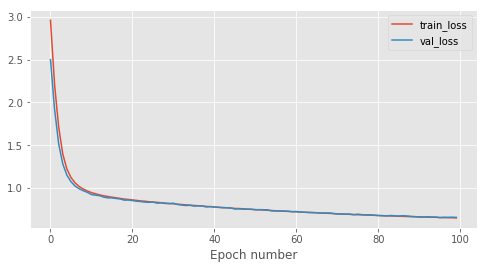

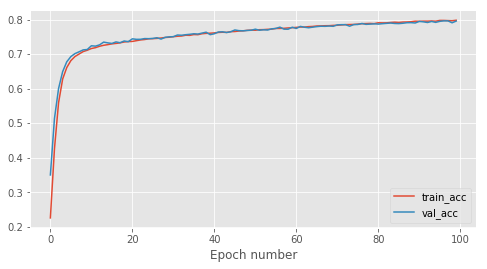

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])


loss: 3.8532, accuracy: 0.0000:   1%|          | 7/1000 [00:00<00:23, 42.88it/s]

torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.7027, accuracy: 0.7900:   1%|          | 11/1000 [00:00<00:16, 58.75it/s]

Epoch 0: train_acc_0.5600_train_loss_1.5590_val_acc_0.7165_val_loss_0.9249 epoch time 19.5659 seconds
total time0.0 : 19.56591010093689


loss: 0.7434, accuracy: 0.7900:   1%|          | 11/1000 [00:00<00:16, 60.08it/s]

Epoch 1: train_acc_0.7409_train_loss_0.8409_val_acc_0.7634_val_loss_0.7556 epoch time 19.2550 seconds
total time0.0 : 38.820932388305664


loss: 0.5748, accuracy: 0.8000:   1%|          | 11/1000 [00:00<00:16, 59.57it/s]

Epoch 2: train_acc_0.7764_train_loss_0.7176_val_acc_0.7915_val_loss_0.6616 epoch time 18.9128 seconds
total time0.0 : 57.73368287086487


loss: 0.4769, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 61.40it/s]

Epoch 3: train_acc_0.7977_train_loss_0.6437_val_acc_0.8078_val_loss_0.6067 epoch time 19.0365 seconds
total time1.0 : 16.770138025283813


loss: 0.3961, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 60.43it/s]

Epoch 4: train_acc_0.8128_train_loss_0.5933_val_acc_0.8131_val_loss_0.5844 epoch time 19.5766 seconds
total time1.0 : 36.346723794937134


loss: 0.6344, accuracy: 0.7900:   1%|          | 11/1000 [00:00<00:16, 60.44it/s]

Epoch 5: train_acc_0.8228_train_loss_0.5545_val_acc_0.8272_val_loss_0.5271 epoch time 18.9152 seconds
total time1.0 : 55.26187753677368


loss: 0.5363, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 60.89it/s]

Epoch 6: train_acc_0.8315_train_loss_0.5213_val_acc_0.8349_val_loss_0.5103 epoch time 19.4409 seconds
total time2.0 : 14.70282244682312


loss: 0.5339, accuracy: 0.7800:   1%|          | 11/1000 [00:00<00:16, 58.51it/s]

Epoch 7: train_acc_0.8395_train_loss_0.4958_val_acc_0.8354_val_loss_0.5043 epoch time 19.0872 seconds
total time2.0 : 33.79000902175903


loss: 0.6441, accuracy: 0.8000:   1%|          | 11/1000 [00:00<00:15, 62.02it/s]

Epoch 8: train_acc_0.8443_train_loss_0.4735_val_acc_0.8502_val_loss_0.4527 epoch time 19.5474 seconds
total time2.0 : 53.33740162849426


loss: 0.3612, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 58.23it/s]

Epoch 9: train_acc_0.8481_train_loss_0.4562_val_acc_0.8538_val_loss_0.4497 epoch time 19.1182 seconds
total time3.0 : 12.455603837966919


loss: 0.3422, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 62.14it/s]

Epoch 10: train_acc_0.8538_train_loss_0.4415_val_acc_0.8537_val_loss_0.4420 epoch time 19.5692 seconds
total time3.0 : 32.0247757434845


loss: 0.3510, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 58.59it/s]

Epoch 11: train_acc_0.8567_train_loss_0.4282_val_acc_0.8541_val_loss_0.4323 epoch time 19.1732 seconds
total time3.0 : 51.19801044464111


loss: 0.2692, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.57it/s]

Epoch 12: train_acc_0.8594_train_loss_0.4172_val_acc_0.8582_val_loss_0.4198 epoch time 19.5380 seconds
total time4.0 : 10.736046552658081


loss: 0.4497, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 58.22it/s]

Epoch 13: train_acc_0.8639_train_loss_0.4070_val_acc_0.8593_val_loss_0.4081 epoch time 19.2610 seconds
total time4.0 : 29.997050523757935


loss: 0.3178, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:15, 63.06it/s]

Epoch 14: train_acc_0.8643_train_loss_0.3986_val_acc_0.8645_val_loss_0.4049 epoch time 19.5129 seconds
total time4.0 : 49.50996780395508


loss: 0.4023, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.04it/s]

Epoch 15: train_acc_0.8669_train_loss_0.3917_val_acc_0.8666_val_loss_0.3959 epoch time 19.1452 seconds
total time5.0 : 8.655131816864014


loss: 0.4428, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 60.96it/s]

Epoch 16: train_acc_0.8685_train_loss_0.3857_val_acc_0.8628_val_loss_0.3953 epoch time 19.5356 seconds
total time5.0 : 28.19070267677307


loss: 0.4634, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 58.90it/s]

Epoch 17: train_acc_0.8700_train_loss_0.3794_val_acc_0.8541_val_loss_0.4038 epoch time 19.0750 seconds
total time5.0 : 47.2657208442688


loss: 0.4900, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 61.19it/s]

Epoch 18: train_acc_0.8712_train_loss_0.3752_val_acc_0.8659_val_loss_0.3882 epoch time 18.9719 seconds
total time6.0 : 6.237664699554443


loss: 0.4333, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:17, 57.75it/s]

Epoch 19: train_acc_0.8730_train_loss_0.3692_val_acc_0.8713_val_loss_0.3765 epoch time 19.0321 seconds
total time6.0 : 25.269749402999878


loss: 0.2602, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.74it/s]

Epoch 20: train_acc_0.8737_train_loss_0.3658_val_acc_0.8693_val_loss_0.3831 epoch time 19.5326 seconds
total time6.0 : 44.80233430862427


loss: 0.2087, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:17, 58.15it/s]

Epoch 21: train_acc_0.8753_train_loss_0.3611_val_acc_0.8665_val_loss_0.3824 epoch time 18.9517 seconds
total time7.0 : 3.7539920806884766


loss: 0.4334, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 60.07it/s]

Epoch 22: train_acc_0.8772_train_loss_0.3581_val_acc_0.8709_val_loss_0.3733 epoch time 19.5576 seconds
total time7.0 : 23.311625003814697


loss: 0.3211, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 59.41it/s]

Epoch 23: train_acc_0.8767_train_loss_0.3545_val_acc_0.8696_val_loss_0.3752 epoch time 19.1069 seconds
total time7.0 : 42.41856932640076


loss: 0.3027, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 61.18it/s]

Epoch 24: train_acc_0.8785_train_loss_0.3517_val_acc_0.8668_val_loss_0.3786 epoch time 19.4997 seconds
total time8.0 : 1.9183032512664795


loss: 0.3876, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 59.54it/s]

Epoch 25: train_acc_0.8788_train_loss_0.3488_val_acc_0.8703_val_loss_0.3667 epoch time 19.1100 seconds
total time8.0 : 21.02827000617981


loss: 0.2845, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:15, 62.45it/s]

Epoch 26: train_acc_0.8797_train_loss_0.3458_val_acc_0.8724_val_loss_0.3718 epoch time 19.5591 seconds
total time8.0 : 40.58732008934021


loss: 0.2879, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:17, 57.97it/s]

Epoch 27: train_acc_0.8817_train_loss_0.3433_val_acc_0.8716_val_loss_0.3738 epoch time 19.0206 seconds
total time8.0 : 59.607930183410645


loss: 0.3340, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 60.39it/s]

Epoch 28: train_acc_0.8818_train_loss_0.3410_val_acc_0.8683_val_loss_0.3727 epoch time 19.5700 seconds
total time9.0 : 19.177916049957275


loss: 0.3525, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 59.62it/s]

Epoch 29: train_acc_0.8810_train_loss_0.3382_val_acc_0.8737_val_loss_0.3620 epoch time 19.0064 seconds
total time9.0 : 38.18427610397339


loss: 0.2715, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.38it/s]

Epoch 30: train_acc_0.8824_train_loss_0.3365_val_acc_0.8720_val_loss_0.3623 epoch time 19.5235 seconds
total time9.0 : 57.70777487754822


loss: 0.2789, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:17, 58.17it/s]

Epoch 31: train_acc_0.8832_train_loss_0.3345_val_acc_0.8732_val_loss_0.3658 epoch time 18.9710 seconds
total time10.0 : 16.67873764038086


loss: 0.2794, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:16, 61.54it/s]

Epoch 32: train_acc_0.8845_train_loss_0.3325_val_acc_0.8740_val_loss_0.3617 epoch time 19.4902 seconds
total time10.0 : 36.16890025138855


loss: 0.3640, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:18, 54.72it/s]

Epoch 33: train_acc_0.8840_train_loss_0.3306_val_acc_0.8699_val_loss_0.3654 epoch time 19.2844 seconds
total time10.0 : 55.45329546928406


loss: 0.2930, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:15, 61.85it/s]

Epoch 34: train_acc_0.8851_train_loss_0.3290_val_acc_0.8691_val_loss_0.3732 epoch time 19.0260 seconds
total time11.0 : 14.479265451431274


loss: 0.3217, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 59.54it/s]

Epoch 35: train_acc_0.8851_train_loss_0.3277_val_acc_0.8781_val_loss_0.3569 epoch time 19.1512 seconds
total time11.0 : 33.63044619560242


loss: 0.2438, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:16, 61.26it/s]

Epoch 36: train_acc_0.8860_train_loss_0.3257_val_acc_0.8704_val_loss_0.3639 epoch time 19.5700 seconds
total time11.0 : 53.200416564941406


loss: 0.2807, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:17, 56.73it/s]

Epoch 37: train_acc_0.8866_train_loss_0.3239_val_acc_0.8756_val_loss_0.3618 epoch time 18.9973 seconds
total time12.0 : 12.197761535644531


loss: 0.2077, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 60.91it/s]

Epoch 38: train_acc_0.8867_train_loss_0.3230_val_acc_0.8758_val_loss_0.3620 epoch time 19.5856 seconds
total time12.0 : 31.78340721130371


loss: 0.2227, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 59.32it/s]

Epoch 39: train_acc_0.8883_train_loss_0.3211_val_acc_0.8680_val_loss_0.3677 epoch time 19.1110 seconds
total time12.0 : 50.89436459541321


loss: 0.2414, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 61.36it/s]

Epoch 40: train_acc_0.8875_train_loss_0.3199_val_acc_0.8774_val_loss_0.3612 epoch time 19.5678 seconds
total time13.0 : 10.462131023406982


loss: 0.2437, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:16, 60.03it/s]

Epoch 41: train_acc_0.8886_train_loss_0.3182_val_acc_0.8731_val_loss_0.3613 epoch time 19.1705 seconds
total time13.0 : 29.632641553878784


loss: 0.2575, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 61.47it/s]

Epoch 42: train_acc_0.8888_train_loss_0.3169_val_acc_0.8709_val_loss_0.3706 epoch time 19.5429 seconds
total time13.0 : 49.1755747795105


loss: 0.3903, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 58.76it/s]

Epoch 43: train_acc_0.8887_train_loss_0.3158_val_acc_0.8769_val_loss_0.3596 epoch time 19.3402 seconds
total time14.0 : 8.515813827514648


loss: 0.2505, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:16, 61.42it/s]

Epoch 44: train_acc_0.8896_train_loss_0.3147_val_acc_0.8740_val_loss_0.3640 epoch time 19.5994 seconds
total time14.0 : 28.1152560710907


loss: 0.2350, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 59.48it/s]

Epoch 45: train_acc_0.8906_train_loss_0.3134_val_acc_0.8742_val_loss_0.3618 epoch time 19.0688 seconds
total time14.0 : 47.18408751487732


loss: 0.3879, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.40it/s]

Epoch 46: train_acc_0.8901_train_loss_0.3124_val_acc_0.8759_val_loss_0.3587 epoch time 19.5192 seconds
total time15.0 : 6.703284740447998


loss: 0.4985, accuracy: 0.8300:   1%|          | 11/1000 [00:00<00:16, 59.30it/s]

Epoch 47: train_acc_0.8908_train_loss_0.3104_val_acc_0.8777_val_loss_0.3555 epoch time 19.1593 seconds
total time15.0 : 25.862581491470337


loss: 0.2898, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 61.56it/s]

Epoch 48: train_acc_0.8902_train_loss_0.3097_val_acc_0.8721_val_loss_0.3646 epoch time 19.4883 seconds
total time15.0 : 45.35089659690857


loss: 0.2534, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.34it/s]

Epoch 49: train_acc_0.8913_train_loss_0.3086_val_acc_0.8772_val_loss_0.3600 epoch time 19.1617 seconds
total time16.0 : 4.512568473815918


loss: 0.3784, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 62.96it/s]

Epoch 50: train_acc_0.8914_train_loss_0.3080_val_acc_0.8778_val_loss_0.3548 epoch time 19.0577 seconds
total time16.0 : 23.570260524749756


loss: 0.2911, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:17, 57.97it/s]

Epoch 51: train_acc_0.8918_train_loss_0.3077_val_acc_0.8777_val_loss_0.3566 epoch time 18.9840 seconds
total time16.0 : 42.554288387298584


loss: 0.3424, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:15, 61.90it/s]

Epoch 52: train_acc_0.8920_train_loss_0.3061_val_acc_0.8778_val_loss_0.3544 epoch time 19.5261 seconds
total time17.0 : 2.0803744792938232


loss: 0.3141, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.43it/s]

Epoch 53: train_acc_0.8917_train_loss_0.3046_val_acc_0.8765_val_loss_0.3553 epoch time 18.9030 seconds
total time17.0 : 20.98340630531311


loss: 0.3044, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:15, 62.00it/s]

Epoch 54: train_acc_0.8921_train_loss_0.3043_val_acc_0.8759_val_loss_0.3596 epoch time 19.5081 seconds
total time17.0 : 40.491472005844116


loss: 0.2183, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:17, 57.33it/s]

Epoch 55: train_acc_0.8933_train_loss_0.3031_val_acc_0.8728_val_loss_0.3571 epoch time 19.1646 seconds
total time17.0 : 59.65609359741211


loss: 0.3467, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:15, 63.42it/s]

Epoch 56: train_acc_0.8937_train_loss_0.3025_val_acc_0.8747_val_loss_0.3563 epoch time 19.5511 seconds
total time18.0 : 19.207164525985718


loss: 0.2264, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:16, 58.53it/s]

Epoch 57: train_acc_0.8939_train_loss_0.3013_val_acc_0.8775_val_loss_0.3637 epoch time 19.1896 seconds
total time18.0 : 38.39680218696594


loss: 0.5347, accuracy: 0.8200:   1%|          | 11/1000 [00:00<00:16, 59.60it/s]

Epoch 58: train_acc_0.8939_train_loss_0.3008_val_acc_0.8754_val_loss_0.3601 epoch time 19.5416 seconds
total time18.0 : 57.93837642669678


loss: 0.2616, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:17, 57.98it/s]

Epoch 59: train_acc_0.8943_train_loss_0.2994_val_acc_0.8775_val_loss_0.3571 epoch time 19.1856 seconds
total time19.0 : 17.12395453453064


loss: 0.2119, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 60.55it/s]

Epoch 60: train_acc_0.8935_train_loss_0.2997_val_acc_0.8740_val_loss_0.3630 epoch time 19.5920 seconds
total time19.0 : 36.71591806411743


loss: 0.3083, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 59.52it/s]

Epoch 61: train_acc_0.8946_train_loss_0.2988_val_acc_0.8777_val_loss_0.3558 epoch time 19.1551 seconds
total time19.0 : 55.871004819869995


loss: 0.2375, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 61.82it/s]

Epoch 62: train_acc_0.8933_train_loss_0.2984_val_acc_0.8746_val_loss_0.3687 epoch time 19.5773 seconds
total time20.0 : 15.448346376419067


loss: 0.3550, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:16, 58.76it/s]

Epoch 63: train_acc_0.8949_train_loss_0.2977_val_acc_0.8767_val_loss_0.3567 epoch time 19.0739 seconds
total time20.0 : 34.52225375175476


loss: 0.2324, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 61.40it/s]

Epoch 64: train_acc_0.8953_train_loss_0.2951_val_acc_0.8704_val_loss_0.3699 epoch time 19.5018 seconds
total time20.0 : 54.02405023574829


loss: 0.1739, accuracy: 0.9500:   1%|          | 11/1000 [00:00<00:16, 59.26it/s]

Epoch 65: train_acc_0.8945_train_loss_0.2958_val_acc_0.8788_val_loss_0.3531 epoch time 19.2108 seconds
total time21.0 : 13.234894275665283


loss: 0.2959, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:15, 62.82it/s]

Epoch 66: train_acc_0.8958_train_loss_0.2947_val_acc_0.8785_val_loss_0.3502 epoch time 19.1114 seconds
total time21.0 : 32.34633708000183


loss: 0.2619, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 59.12it/s]

Epoch 67: train_acc_0.8950_train_loss_0.2937_val_acc_0.8785_val_loss_0.3570 epoch time 19.0794 seconds
total time21.0 : 51.42571544647217


loss: 0.3010, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 60.65it/s]

Epoch 68: train_acc_0.8956_train_loss_0.2929_val_acc_0.8784_val_loss_0.3542 epoch time 19.6002 seconds
total time22.0 : 11.025942087173462


loss: 0.2880, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:17, 57.08it/s]

Epoch 69: train_acc_0.8959_train_loss_0.2920_val_acc_0.8772_val_loss_0.3570 epoch time 18.9360 seconds
total time22.0 : 29.96196961402893


loss: 0.2971, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.75it/s]

Epoch 70: train_acc_0.8962_train_loss_0.2920_val_acc_0.8795_val_loss_0.3533 epoch time 19.5625 seconds
total time22.0 : 49.524500608444214


loss: 0.4135, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 59.06it/s]

Epoch 71: train_acc_0.8965_train_loss_0.2908_val_acc_0.8768_val_loss_0.3563 epoch time 19.2316 seconds
total time23.0 : 8.756124019622803


loss: 0.1974, accuracy: 0.9500:   1%|          | 11/1000 [00:00<00:15, 61.91it/s]

Epoch 72: train_acc_0.8952_train_loss_0.2913_val_acc_0.8782_val_loss_0.3534 epoch time 19.5702 seconds
total time23.0 : 28.32633686065674


loss: 0.4404, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.17it/s]

Epoch 73: train_acc_0.8966_train_loss_0.2894_val_acc_0.8787_val_loss_0.3579 epoch time 19.0750 seconds
total time23.0 : 47.40134119987488


loss: 0.2217, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.13it/s]

Epoch 74: train_acc_0.8967_train_loss_0.2893_val_acc_0.8737_val_loss_0.3644 epoch time 19.6129 seconds
total time24.0 : 7.014275312423706


loss: 0.3302, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 58.94it/s]

Epoch 75: train_acc_0.8973_train_loss_0.2882_val_acc_0.8797_val_loss_0.3586 epoch time 19.1314 seconds
total time24.0 : 26.145633220672607


loss: 0.2789, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:15, 61.83it/s]

Epoch 76: train_acc_0.8965_train_loss_0.2883_val_acc_0.8776_val_loss_0.3596 epoch time 19.5350 seconds
total time24.0 : 45.68064761161804


loss: 0.3531, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:17, 56.03it/s]

Epoch 77: train_acc_0.8983_train_loss_0.2870_val_acc_0.8771_val_loss_0.3609 epoch time 19.2668 seconds
total time25.0 : 4.947424411773682


loss: 0.3460, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 61.52it/s]

Epoch 78: train_acc_0.8972_train_loss_0.2866_val_acc_0.8782_val_loss_0.3539 epoch time 19.5468 seconds
total time25.0 : 24.4941885471344


loss: 0.2383, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 58.69it/s]

Epoch 79: train_acc_0.8976_train_loss_0.2856_val_acc_0.8780_val_loss_0.3560 epoch time 19.0743 seconds
total time25.0 : 43.56850814819336


loss: 0.1749, accuracy: 0.9500:   1%|          | 11/1000 [00:00<00:16, 61.54it/s]

Epoch 80: train_acc_0.8982_train_loss_0.2848_val_acc_0.8754_val_loss_0.3585 epoch time 19.5895 seconds
total time26.0 : 3.1580121517181396


loss: 0.2374, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:17, 58.11it/s]

Epoch 81: train_acc_0.8974_train_loss_0.2854_val_acc_0.8772_val_loss_0.3534 epoch time 19.1327 seconds
total time26.0 : 22.290730714797974


loss: 0.1440, accuracy: 0.9500:   1%|          | 12/1000 [00:00<00:15, 61.93it/s]

Epoch 82: train_acc_0.8986_train_loss_0.2841_val_acc_0.8790_val_loss_0.3540 epoch time 19.2198 seconds
total time26.0 : 41.51051092147827


loss: 0.4189, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 58.88it/s]

Epoch 83: train_acc_0.8974_train_loss_0.2847_val_acc_0.8803_val_loss_0.3512 epoch time 19.1340 seconds
total time27.0 : 0.6445364952087402


loss: 0.2512, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 61.93it/s]

Epoch 84: train_acc_0.8992_train_loss_0.2833_val_acc_0.8787_val_loss_0.3537 epoch time 19.5638 seconds
total time27.0 : 20.208330631256104


loss: 0.3279, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.44it/s]

Epoch 85: train_acc_0.8986_train_loss_0.2833_val_acc_0.8764_val_loss_0.3568 epoch time 19.0129 seconds
total time27.0 : 39.22123098373413


loss: 0.1966, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:16, 59.80it/s]

Epoch 86: train_acc_0.8980_train_loss_0.2828_val_acc_0.8771_val_loss_0.3578 epoch time 19.5883 seconds
total time27.0 : 58.809490442276


loss: 0.2283, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:16, 59.99it/s]

Epoch 87: train_acc_0.8988_train_loss_0.2818_val_acc_0.8792_val_loss_0.3554 epoch time 19.2868 seconds
total time28.0 : 18.09631109237671


loss: 0.3812, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 60.01it/s]

Epoch 88: train_acc_0.8995_train_loss_0.2812_val_acc_0.8794_val_loss_0.3602 epoch time 19.5281 seconds
total time28.0 : 37.62442874908447


loss: 0.3006, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.06it/s]

Epoch 89: train_acc_0.8995_train_loss_0.2809_val_acc_0.8782_val_loss_0.3560 epoch time 19.0032 seconds
total time28.0 : 56.62765169143677


loss: 0.2381, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 61.67it/s]

Epoch 90: train_acc_0.9000_train_loss_0.2800_val_acc_0.8785_val_loss_0.3571 epoch time 19.4955 seconds
total time29.0 : 16.123140811920166


loss: 0.3703, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 59.16it/s]

Epoch 91: train_acc_0.8995_train_loss_0.2796_val_acc_0.8755_val_loss_0.3593 epoch time 19.0579 seconds
total time29.0 : 35.18104386329651


loss: 0.2517, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.48it/s]

Epoch 92: train_acc_0.8998_train_loss_0.2788_val_acc_0.8794_val_loss_0.3552 epoch time 19.5447 seconds
total time29.0 : 54.72571635246277


loss: 0.3353, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 58.91it/s]

Epoch 93: train_acc_0.8998_train_loss_0.2790_val_acc_0.8749_val_loss_0.3625 epoch time 19.0125 seconds
total time30.0 : 13.738186120986938


loss: 0.2063, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.72it/s]

Epoch 94: train_acc_0.8995_train_loss_0.2780_val_acc_0.8801_val_loss_0.3578 epoch time 19.5668 seconds
total time30.0 : 33.304961919784546


loss: 0.1853, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:16, 59.17it/s]

Epoch 95: train_acc_0.8996_train_loss_0.2781_val_acc_0.8737_val_loss_0.3615 epoch time 19.1583 seconds
total time30.0 : 52.463299036026


loss: 0.2499, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.55it/s]

Epoch 96: train_acc_0.9005_train_loss_0.2771_val_acc_0.8794_val_loss_0.3579 epoch time 19.5002 seconds
total time31.0 : 11.963523864746094


loss: 0.2779, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:17, 57.94it/s]

Epoch 97: train_acc_0.9013_train_loss_0.2766_val_acc_0.8780_val_loss_0.3572 epoch time 19.0837 seconds
total time31.0 : 31.047231674194336


loss: 0.4174, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 61.43it/s]

Epoch 98: train_acc_0.9011_train_loss_0.2761_val_acc_0.8777_val_loss_0.3603 epoch time 19.2590 seconds
total time31.0 : 50.30623388290405


loss: 0.4080, accuracy: 0.8900:  14%|█▍        | 22/158 [00:00<00:01, 124.80it/s]

Epoch 99: train_acc_0.9014_train_loss_0.2755_val_acc_0.8789_val_loss_0.3534 epoch time 18.8765 seconds
total time32.0 : 9.182694435119629
Generating test set evaluation metrics


loss: 0.3751, accuracy: 0.8400: 100%|██████████| 158/158 [00:01<00:00, 103.42it/s]


finish


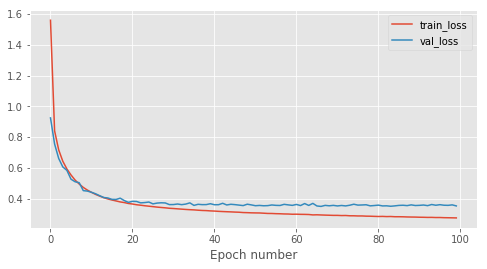

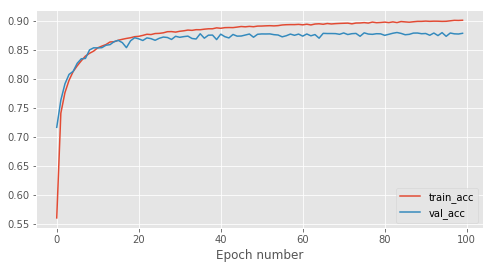

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])


loss: 3.8366, accuracy: 0.0100:   1%|          | 8/1000 [00:00<00:21, 47.00it/s]

torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.6310, accuracy: 0.7600:   1%|          | 10/1000 [00:00<00:18, 54.49it/s]

Epoch 0: train_acc_0.6533_train_loss_1.1868_val_acc_0.8006_val_loss_0.6241 epoch time 21.6124 seconds
total time0.0 : 21.612369775772095


loss: 0.4250, accuracy: 0.8400:   1%|          | 10/1000 [00:00<00:18, 53.53it/s]

Epoch 1: train_acc_0.8172_train_loss_0.5546_val_acc_0.8414_val_loss_0.4705 epoch time 21.6692 seconds
total time0.0 : 43.281607151031494


loss: 0.3317, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 53.07it/s]

Epoch 2: train_acc_0.8399_train_loss_0.4711_val_acc_0.8375_val_loss_0.4620 epoch time 21.6818 seconds
total time1.0 : 4.963417053222656


loss: 0.3573, accuracy: 0.8500:   1%|          | 9/1000 [00:00<00:18, 52.57it/s]

Epoch 3: train_acc_0.8542_train_loss_0.4266_val_acc_0.8586_val_loss_0.4105 epoch time 21.6572 seconds
total time1.0 : 26.620582580566406


loss: 0.3113, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.43it/s]

Epoch 4: train_acc_0.8619_train_loss_0.4007_val_acc_0.8541_val_loss_0.3996 epoch time 21.6744 seconds
total time1.0 : 48.2950325012207


loss: 0.4181, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:19, 50.85it/s]

Epoch 5: train_acc_0.8674_train_loss_0.3796_val_acc_0.8709_val_loss_0.3648 epoch time 21.7178 seconds
total time2.0 : 10.012836933135986


loss: 0.2975, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 53.55it/s]

Epoch 6: train_acc_0.8721_train_loss_0.3653_val_acc_0.8665_val_loss_0.3799 epoch time 21.7221 seconds
total time2.0 : 31.73494553565979


loss: 0.3063, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:18, 53.61it/s]

Epoch 7: train_acc_0.8749_train_loss_0.3530_val_acc_0.8725_val_loss_0.3613 epoch time 21.6895 seconds
total time2.0 : 53.424474477767944


loss: 0.2150, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:17, 55.10it/s]

Epoch 8: train_acc_0.8775_train_loss_0.3443_val_acc_0.8823_val_loss_0.3389 epoch time 21.6957 seconds
total time3.0 : 15.120177507400513


loss: 0.2807, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 54.18it/s]

Epoch 9: train_acc_0.8812_train_loss_0.3332_val_acc_0.8809_val_loss_0.3390 epoch time 21.6856 seconds
total time3.0 : 36.80575513839722


loss: 0.2438, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 53.11it/s]

Epoch 10: train_acc_0.8836_train_loss_0.3247_val_acc_0.8835_val_loss_0.3350 epoch time 21.6367 seconds
total time3.0 : 58.44249987602234


loss: 0.2711, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.36it/s]

Epoch 11: train_acc_0.8859_train_loss_0.3167_val_acc_0.8773_val_loss_0.3439 epoch time 21.7414 seconds
total time4.0 : 20.183857679367065


loss: 0.4641, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:18, 53.08it/s]

Epoch 12: train_acc_0.8883_train_loss_0.3095_val_acc_0.8849_val_loss_0.3284 epoch time 21.6540 seconds
total time4.0 : 41.83787560462952


loss: 0.4203, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 52.55it/s]

Epoch 13: train_acc_0.8901_train_loss_0.3039_val_acc_0.8792_val_loss_0.3440 epoch time 21.4264 seconds
total time5.0 : 3.264249324798584


loss: 0.4852, accuracy: 0.8400:   1%|          | 10/1000 [00:00<00:18, 52.43it/s]

Epoch 14: train_acc_0.8911_train_loss_0.2975_val_acc_0.8833_val_loss_0.3354 epoch time 21.5446 seconds
total time5.0 : 24.80881690979004


loss: 0.2788, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.27it/s]

Epoch 15: train_acc_0.8931_train_loss_0.2931_val_acc_0.8847_val_loss_0.3284 epoch time 21.7890 seconds
total time5.0 : 46.597809076309204


loss: 0.2246, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.66it/s]

Epoch 16: train_acc_0.8944_train_loss_0.2879_val_acc_0.8834_val_loss_0.3323 epoch time 21.7834 seconds
total time6.0 : 8.381231784820557


loss: 0.3115, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.28it/s]

Epoch 17: train_acc_0.8963_train_loss_0.2814_val_acc_0.8829_val_loss_0.3399 epoch time 21.7418 seconds
total time6.0 : 30.12299919128418


loss: 0.1946, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.31it/s]

Epoch 18: train_acc_0.8972_train_loss_0.2784_val_acc_0.8865_val_loss_0.3288 epoch time 21.7101 seconds
total time6.0 : 51.83307957649231


loss: 0.1324, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.60it/s]

Epoch 19: train_acc_0.9000_train_loss_0.2728_val_acc_0.8863_val_loss_0.3306 epoch time 21.7416 seconds
total time7.0 : 13.574649810791016


loss: 0.1637, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.48it/s]

Epoch 20: train_acc_0.8996_train_loss_0.2692_val_acc_0.8795_val_loss_0.3349 epoch time 21.7354 seconds
total time7.0 : 35.31004452705383


loss: 0.2442, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:18, 52.37it/s]

Epoch 21: train_acc_0.9014_train_loss_0.2649_val_acc_0.8815_val_loss_0.3454 epoch time 21.7918 seconds
total time7.0 : 57.10185122489929


loss: 0.1317, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.45it/s]

Epoch 22: train_acc_0.9028_train_loss_0.2612_val_acc_0.8862_val_loss_0.3315 epoch time 21.7489 seconds
total time8.0 : 18.850760221481323


loss: 0.2890, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 53.17it/s]

Epoch 23: train_acc_0.9039_train_loss_0.2561_val_acc_0.8851_val_loss_0.3392 epoch time 21.7922 seconds
total time8.0 : 40.64297032356262


loss: 0.2123, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.92it/s]

Epoch 24: train_acc_0.9051_train_loss_0.2544_val_acc_0.8792_val_loss_0.3422 epoch time 21.7381 seconds
total time9.0 : 2.381096839904785


loss: 0.3657, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 52.08it/s]

Epoch 25: train_acc_0.9062_train_loss_0.2510_val_acc_0.8818_val_loss_0.3370 epoch time 21.7771 seconds
total time9.0 : 24.158165454864502


loss: 0.2848, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 52.64it/s]

Epoch 26: train_acc_0.9066_train_loss_0.2475_val_acc_0.8778_val_loss_0.3487 epoch time 21.7373 seconds
total time9.0 : 45.89543557167053


loss: 0.2559, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 53.54it/s]

Epoch 27: train_acc_0.9074_train_loss_0.2439_val_acc_0.8832_val_loss_0.3423 epoch time 21.3788 seconds
total time10.0 : 7.274285078048706


loss: 0.2213, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:17, 55.32it/s]

Epoch 28: train_acc_0.9086_train_loss_0.2410_val_acc_0.8813_val_loss_0.3411 epoch time 21.5221 seconds
total time10.0 : 28.796411275863647


loss: 0.2799, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.94it/s]

Epoch 29: train_acc_0.9083_train_loss_0.2397_val_acc_0.8809_val_loss_0.3494 epoch time 21.6466 seconds
total time10.0 : 50.44305396080017


loss: 0.1746, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.04it/s]

Epoch 30: train_acc_0.9110_train_loss_0.2341_val_acc_0.8834_val_loss_0.3411 epoch time 21.6794 seconds
total time11.0 : 12.122443914413452


loss: 0.2151, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.33it/s]

Epoch 31: train_acc_0.9112_train_loss_0.2333_val_acc_0.8740_val_loss_0.3616 epoch time 21.6911 seconds
total time11.0 : 33.81350541114807


loss: 0.1312, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.85it/s]

Epoch 32: train_acc_0.9122_train_loss_0.2290_val_acc_0.8825_val_loss_0.3409 epoch time 21.7240 seconds
total time11.0 : 55.537476778030396


loss: 0.1857, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.42it/s]

Epoch 33: train_acc_0.9133_train_loss_0.2270_val_acc_0.8797_val_loss_0.3523 epoch time 21.7009 seconds
total time12.0 : 17.23836588859558


loss: 0.1571, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.52it/s]

Epoch 34: train_acc_0.9136_train_loss_0.2255_val_acc_0.8801_val_loss_0.3565 epoch time 21.6631 seconds
total time12.0 : 38.901443004608154


loss: 0.2207, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.81it/s]

Epoch 35: train_acc_0.9146_train_loss_0.2222_val_acc_0.8815_val_loss_0.3559 epoch time 21.6740 seconds
total time13.0 : 0.5754146575927734


loss: 0.2073, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.61it/s]

Epoch 36: train_acc_0.9153_train_loss_0.2193_val_acc_0.8820_val_loss_0.3576 epoch time 21.7266 seconds
total time13.0 : 22.302011966705322


loss: 0.1734, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.39it/s]

Epoch 37: train_acc_0.9164_train_loss_0.2176_val_acc_0.8774_val_loss_0.3688 epoch time 21.6761 seconds
total time13.0 : 43.97812366485596


loss: 0.1328, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:18, 52.98it/s]

Epoch 38: train_acc_0.9170_train_loss_0.2151_val_acc_0.8825_val_loss_0.3550 epoch time 21.7318 seconds
total time14.0 : 5.709883451461792


loss: 0.2487, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.76it/s]

Epoch 39: train_acc_0.9179_train_loss_0.2126_val_acc_0.8773_val_loss_0.3660 epoch time 21.8457 seconds
total time14.0 : 27.555586099624634


loss: 0.2437, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.98it/s]

Epoch 40: train_acc_0.9176_train_loss_0.2113_val_acc_0.8822_val_loss_0.3659 epoch time 21.9023 seconds
total time14.0 : 49.45789885520935


loss: 0.1571, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.82it/s]

Epoch 41: train_acc_0.9190_train_loss_0.2087_val_acc_0.8765_val_loss_0.3736 epoch time 21.5785 seconds
total time15.0 : 11.036429405212402


loss: 0.1220, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.39it/s]

Epoch 42: train_acc_0.9204_train_loss_0.2055_val_acc_0.8780_val_loss_0.3676 epoch time 21.5767 seconds
total time15.0 : 32.61311650276184


loss: 0.1486, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.74it/s]

Epoch 43: train_acc_0.9204_train_loss_0.2042_val_acc_0.8773_val_loss_0.3738 epoch time 21.6473 seconds
total time15.0 : 54.26041054725647


loss: 0.1944, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 53.06it/s]

Epoch 44: train_acc_0.9215_train_loss_0.2016_val_acc_0.8793_val_loss_0.3823 epoch time 21.7234 seconds
total time16.0 : 15.983821868896484


loss: 0.1609, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 53.50it/s]

Epoch 45: train_acc_0.9222_train_loss_0.1990_val_acc_0.8777_val_loss_0.3832 epoch time 21.7345 seconds
total time16.0 : 37.71833848953247


loss: 0.1828, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.86it/s]

Epoch 46: train_acc_0.9226_train_loss_0.1978_val_acc_0.8788_val_loss_0.3760 epoch time 21.7644 seconds
total time16.0 : 59.48277306556702


loss: 0.1519, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.25it/s]

Epoch 47: train_acc_0.9233_train_loss_0.1955_val_acc_0.8791_val_loss_0.3810 epoch time 21.7360 seconds
total time17.0 : 21.218735694885254


loss: 0.2509, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:18, 52.93it/s]

Epoch 48: train_acc_0.9242_train_loss_0.1922_val_acc_0.8773_val_loss_0.3818 epoch time 21.7317 seconds
total time17.0 : 42.95048117637634


loss: 0.1608, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.96it/s]

Epoch 49: train_acc_0.9245_train_loss_0.1921_val_acc_0.8751_val_loss_0.4018 epoch time 21.7415 seconds
total time18.0 : 4.691945552825928


loss: 0.1203, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.61it/s]

Epoch 50: train_acc_0.9247_train_loss_0.1904_val_acc_0.8741_val_loss_0.3908 epoch time 21.6970 seconds
total time18.0 : 26.388975858688354


loss: 0.1719, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:18, 53.75it/s]

Epoch 51: train_acc_0.9258_train_loss_0.1879_val_acc_0.8759_val_loss_0.4018 epoch time 21.6891 seconds
total time18.0 : 48.07808756828308


loss: 0.1141, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:18, 52.42it/s]

Epoch 52: train_acc_0.9267_train_loss_0.1847_val_acc_0.8728_val_loss_0.4051 epoch time 21.7643 seconds
total time19.0 : 9.84243106842041


loss: 0.1545, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.69it/s]

Epoch 53: train_acc_0.9266_train_loss_0.1851_val_acc_0.8730_val_loss_0.4023 epoch time 21.7693 seconds
total time19.0 : 31.611737966537476


loss: 0.2017, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.88it/s]

Epoch 54: train_acc_0.9275_train_loss_0.1826_val_acc_0.8751_val_loss_0.4039 epoch time 21.7591 seconds
total time19.0 : 53.37085270881653


loss: 0.1842, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.87it/s]

Epoch 55: train_acc_0.9274_train_loss_0.1802_val_acc_0.8749_val_loss_0.4062 epoch time 21.7312 seconds
total time20.0 : 15.10202670097351


loss: 0.1614, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.63it/s]

Epoch 56: train_acc_0.9290_train_loss_0.1791_val_acc_0.8755_val_loss_0.4097 epoch time 21.3596 seconds
total time20.0 : 36.46164917945862


loss: 0.2032, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 53.35it/s]

Epoch 57: train_acc_0.9289_train_loss_0.1772_val_acc_0.8735_val_loss_0.4163 epoch time 21.6851 seconds
total time20.0 : 58.14673447608948


loss: 0.3569, accuracy: 0.8500:   1%|          | 10/1000 [00:00<00:18, 54.11it/s]

Epoch 58: train_acc_0.9297_train_loss_0.1764_val_acc_0.8777_val_loss_0.4073 epoch time 21.7288 seconds
total time21.0 : 19.875532865524292


loss: 0.1882, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.80it/s]

Epoch 59: train_acc_0.9313_train_loss_0.1736_val_acc_0.8736_val_loss_0.4175 epoch time 21.6831 seconds
total time21.0 : 41.55863356590271


loss: 0.1698, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:18, 52.24it/s]

Epoch 60: train_acc_0.9308_train_loss_0.1728_val_acc_0.8659_val_loss_0.4531 epoch time 21.7676 seconds
total time22.0 : 3.3261873722076416


loss: 0.1030, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.16it/s]

Epoch 61: train_acc_0.9313_train_loss_0.1713_val_acc_0.8698_val_loss_0.4258 epoch time 21.7120 seconds
total time22.0 : 25.03820776939392


loss: 0.1471, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.65it/s]

Epoch 62: train_acc_0.9314_train_loss_0.1707_val_acc_0.8706_val_loss_0.4304 epoch time 21.7340 seconds
total time22.0 : 46.77217149734497


loss: 0.1778, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 53.84it/s]

Epoch 63: train_acc_0.9332_train_loss_0.1683_val_acc_0.8716_val_loss_0.4456 epoch time 21.7252 seconds
total time23.0 : 8.497332572937012


loss: 0.1811, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.80it/s]

Epoch 64: train_acc_0.9326_train_loss_0.1678_val_acc_0.8725_val_loss_0.4404 epoch time 21.7111 seconds
total time23.0 : 30.20845341682434


loss: 0.1589, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.24it/s]

Epoch 65: train_acc_0.9346_train_loss_0.1649_val_acc_0.8716_val_loss_0.4390 epoch time 21.7690 seconds
total time23.0 : 51.97740626335144


loss: 0.1324, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 52.49it/s]

Epoch 66: train_acc_0.9338_train_loss_0.1636_val_acc_0.8747_val_loss_0.4430 epoch time 21.7284 seconds
total time24.0 : 13.705832242965698


loss: 0.1276, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.35it/s]

Epoch 67: train_acc_0.9350_train_loss_0.1624_val_acc_0.8713_val_loss_0.4438 epoch time 21.6907 seconds
total time24.0 : 35.396535873413086


loss: 0.1055, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 50.77it/s]

Epoch 68: train_acc_0.9357_train_loss_0.1602_val_acc_0.8720_val_loss_0.4431 epoch time 21.7270 seconds
total time24.0 : 57.123584508895874


loss: 0.1293, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.11it/s]

Epoch 69: train_acc_0.9353_train_loss_0.1593_val_acc_0.8668_val_loss_0.4703 epoch time 21.7567 seconds
total time25.0 : 18.880243062973022


loss: 0.1752, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.86it/s]

Epoch 70: train_acc_0.9363_train_loss_0.1589_val_acc_0.8680_val_loss_0.4617 epoch time 21.4015 seconds
total time25.0 : 40.28172445297241


loss: 0.2358, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 53.23it/s]

Epoch 71: train_acc_0.9368_train_loss_0.1563_val_acc_0.8711_val_loss_0.4631 epoch time 21.6474 seconds
total time26.0 : 1.9290988445281982


loss: 0.1330, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 54.33it/s]

Epoch 72: train_acc_0.9372_train_loss_0.1561_val_acc_0.8697_val_loss_0.4794 epoch time 21.7617 seconds
total time26.0 : 23.69077968597412


loss: 0.1079, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.33it/s]

Epoch 73: train_acc_0.9385_train_loss_0.1538_val_acc_0.8690_val_loss_0.4811 epoch time 21.7384 seconds
total time26.0 : 45.42919993400574


loss: 0.0922, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 52.83it/s]

Epoch 74: train_acc_0.9380_train_loss_0.1537_val_acc_0.8689_val_loss_0.4786 epoch time 21.7063 seconds
total time27.0 : 7.1355202198028564


loss: 0.1563, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.48it/s]

Epoch 75: train_acc_0.9393_train_loss_0.1511_val_acc_0.8718_val_loss_0.4822 epoch time 21.7380 seconds
total time27.0 : 28.873564958572388


loss: 0.1310, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.77it/s]

Epoch 76: train_acc_0.9394_train_loss_0.1500_val_acc_0.8713_val_loss_0.4765 epoch time 21.7761 seconds
total time27.0 : 50.64970541000366


loss: 0.1433, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 52.25it/s]

Epoch 77: train_acc_0.9395_train_loss_0.1484_val_acc_0.8709_val_loss_0.4786 epoch time 21.7090 seconds
total time28.0 : 12.358714580535889


loss: 0.1183, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 53.49it/s]

Epoch 78: train_acc_0.9406_train_loss_0.1477_val_acc_0.8690_val_loss_0.4879 epoch time 21.7730 seconds
total time28.0 : 34.13172936439514


loss: 0.1678, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 52.52it/s]

Epoch 79: train_acc_0.9410_train_loss_0.1472_val_acc_0.8700_val_loss_0.4967 epoch time 21.7388 seconds
total time28.0 : 55.87052273750305


loss: 0.0958, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.92it/s]

Epoch 80: train_acc_0.9418_train_loss_0.1445_val_acc_0.8696_val_loss_0.4930 epoch time 21.7268 seconds
total time29.0 : 17.59731388092041


loss: 0.0981, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.36it/s]

Epoch 81: train_acc_0.9408_train_loss_0.1453_val_acc_0.8692_val_loss_0.4944 epoch time 21.7514 seconds
total time29.0 : 39.34869456291199


loss: 0.0964, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.99it/s]

Epoch 82: train_acc_0.9420_train_loss_0.1437_val_acc_0.8706_val_loss_0.4900 epoch time 21.7504 seconds
total time30.0 : 1.0990889072418213


loss: 0.1557, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 52.26it/s]

Epoch 83: train_acc_0.9422_train_loss_0.1429_val_acc_0.8694_val_loss_0.5140 epoch time 21.7028 seconds
total time30.0 : 22.80186104774475


loss: 0.1199, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.92it/s]

Epoch 84: train_acc_0.9438_train_loss_0.1402_val_acc_0.8683_val_loss_0.5172 epoch time 21.4752 seconds
total time30.0 : 44.277101039886475


loss: 0.1061, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:18, 52.62it/s]

Epoch 85: train_acc_0.9427_train_loss_0.1401_val_acc_0.8691_val_loss_0.5161 epoch time 21.5846 seconds
total time31.0 : 5.861711263656616


loss: 0.0889, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.04it/s]

Epoch 86: train_acc_0.9444_train_loss_0.1384_val_acc_0.8660_val_loss_0.5248 epoch time 21.6792 seconds
total time31.0 : 27.540879249572754


loss: 0.1577, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.40it/s]

Epoch 87: train_acc_0.9439_train_loss_0.1384_val_acc_0.8677_val_loss_0.5155 epoch time 21.7586 seconds
total time31.0 : 49.29951882362366


loss: 0.1256, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:19, 51.79it/s]

Epoch 88: train_acc_0.9451_train_loss_0.1369_val_acc_0.8669_val_loss_0.5154 epoch time 21.7597 seconds
total time32.0 : 11.05917739868164


loss: 0.1130, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.95it/s]

Epoch 89: train_acc_0.9451_train_loss_0.1354_val_acc_0.8669_val_loss_0.5349 epoch time 21.7155 seconds
total time32.0 : 32.77471160888672


loss: 0.1195, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 53.15it/s]

Epoch 90: train_acc_0.9461_train_loss_0.1338_val_acc_0.8652_val_loss_0.5393 epoch time 21.7454 seconds
total time32.0 : 54.5201256275177


loss: 0.1469, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.31it/s]

Epoch 91: train_acc_0.9461_train_loss_0.1328_val_acc_0.8652_val_loss_0.5434 epoch time 21.7783 seconds
total time33.0 : 16.29837989807129


loss: 0.0983, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.21it/s]

Epoch 92: train_acc_0.9460_train_loss_0.1327_val_acc_0.8682_val_loss_0.5467 epoch time 21.7502 seconds
total time33.0 : 38.048622369766235


loss: 0.1176, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.23it/s]

Epoch 93: train_acc_0.9464_train_loss_0.1325_val_acc_0.8672_val_loss_0.5491 epoch time 21.7498 seconds
total time33.0 : 59.79847192764282


loss: 0.2318, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.66it/s]

Epoch 94: train_acc_0.9469_train_loss_0.1308_val_acc_0.8668_val_loss_0.5442 epoch time 21.7335 seconds
total time34.0 : 21.531981706619263


loss: 0.1000, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 52.36it/s]

Epoch 95: train_acc_0.9483_train_loss_0.1281_val_acc_0.8690_val_loss_0.5436 epoch time 21.7334 seconds
total time34.0 : 43.26535654067993


loss: 0.0773, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:19, 51.81it/s]

Epoch 96: train_acc_0.9485_train_loss_0.1277_val_acc_0.8656_val_loss_0.5523 epoch time 21.7442 seconds
total time35.0 : 5.0095295906066895


loss: 0.1296, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:19, 51.69it/s]

Epoch 97: train_acc_0.9481_train_loss_0.1281_val_acc_0.8666_val_loss_0.5554 epoch time 21.7394 seconds
total time35.0 : 26.748894691467285


loss: 0.1108, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 54.22it/s]

Epoch 98: train_acc_0.9491_train_loss_0.1252_val_acc_0.8677_val_loss_0.5479 epoch time 21.6567 seconds
total time35.0 : 48.405592918395996


loss: 0.4211, accuracy: 0.8300:  13%|█▎        | 20/158 [00:00<00:01, 109.31it/s]

Epoch 99: train_acc_0.9491_train_loss_0.1248_val_acc_0.8643_val_loss_0.5608 epoch time 21.6056 seconds
total time36.0 : 10.01122522354126
Generating test set evaluation metrics


loss: 0.3275, accuracy: 0.8600: 100%|██████████| 158/158 [00:01<00:00, 96.87it/s]


finish


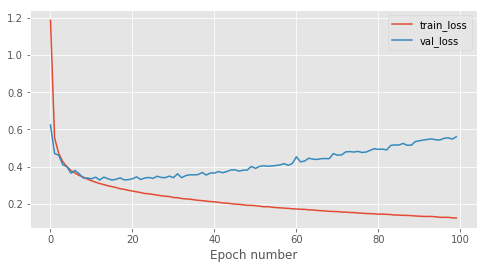

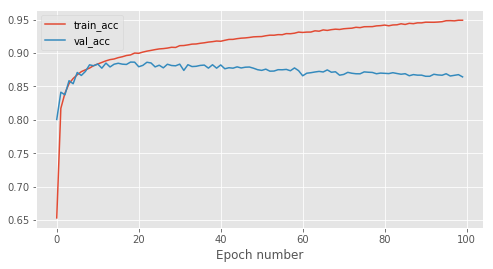

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])


loss: 3.8475, accuracy: 0.0200:   1%|          | 7/1000 [00:00<00:22, 44.82it/s]

torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 3, 3])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=

loss: 0.4434, accuracy: 0.8200:   1%|          | 9/1000 [00:00<00:20, 47.70it/s]

Epoch 0: train_acc_0.6910_train_loss_1.0218_val_acc_0.8283_val_loss_0.5000 epoch time 23.7178 seconds
total time0.0 : 23.717756271362305


loss: 0.5203, accuracy: 0.8300:   1%|          | 8/1000 [00:00<00:20, 47.76it/s]

Epoch 1: train_acc_0.8368_train_loss_0.4721_val_acc_0.8641_val_loss_0.3974 epoch time 23.6876 seconds
total time0.0 : 47.40534281730652


loss: 0.3996, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:19, 49.81it/s]

Epoch 2: train_acc_0.8579_train_loss_0.4023_val_acc_0.8675_val_loss_0.3747 epoch time 23.7022 seconds
total time1.0 : 11.107568264007568


loss: 0.4199, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 48.68it/s]

Epoch 3: train_acc_0.8706_train_loss_0.3649_val_acc_0.8722_val_loss_0.3566 epoch time 23.6162 seconds
total time1.0 : 34.72378754615784


loss: 0.2851, accuracy: 0.8600:   1%|          | 8/1000 [00:00<00:21, 47.00it/s]

Epoch 4: train_acc_0.8760_train_loss_0.3410_val_acc_0.8711_val_loss_0.3526 epoch time 23.7166 seconds
total time1.0 : 58.44035744667053


loss: 0.3548, accuracy: 0.8500:   1%|          | 9/1000 [00:00<00:20, 48.71it/s]

Epoch 5: train_acc_0.8830_train_loss_0.3218_val_acc_0.8773_val_loss_0.3350 epoch time 23.7138 seconds
total time2.0 : 22.154160737991333


loss: 0.3259, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 49.41it/s]

Epoch 6: train_acc_0.8867_train_loss_0.3057_val_acc_0.8769_val_loss_0.3411 epoch time 23.7158 seconds
total time2.0 : 45.86991333961487


loss: 0.2171, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 47.21it/s]

Epoch 7: train_acc_0.8907_train_loss_0.2923_val_acc_0.8820_val_loss_0.3289 epoch time 23.7045 seconds
total time3.0 : 9.57439923286438


loss: 0.3046, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 47.82it/s]

Epoch 8: train_acc_0.8948_train_loss_0.2793_val_acc_0.8825_val_loss_0.3295 epoch time 23.7028 seconds
total time3.0 : 33.277238607406616


loss: 0.2581, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 47.59it/s]

Epoch 9: train_acc_0.8981_train_loss_0.2687_val_acc_0.8837_val_loss_0.3210 epoch time 23.6685 seconds
total time3.0 : 56.945775270462036


loss: 0.2003, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.66it/s]

Epoch 10: train_acc_0.9000_train_loss_0.2582_val_acc_0.8786_val_loss_0.3353 epoch time 23.6140 seconds
total time4.0 : 20.559730768203735


loss: 0.2801, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 48.73it/s]

Epoch 11: train_acc_0.9032_train_loss_0.2490_val_acc_0.8815_val_loss_0.3421 epoch time 23.7029 seconds
total time4.0 : 44.26267147064209


loss: 0.1575, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.75it/s]

Epoch 12: train_acc_0.9065_train_loss_0.2403_val_acc_0.8847_val_loss_0.3287 epoch time 23.3368 seconds
total time5.0 : 7.599493741989136


loss: 0.1377, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.66it/s]

Epoch 13: train_acc_0.9091_train_loss_0.2314_val_acc_0.8802_val_loss_0.3365 epoch time 23.6834 seconds
total time5.0 : 31.282859563827515


loss: 0.3170, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 49.22it/s]

Epoch 14: train_acc_0.9119_train_loss_0.2231_val_acc_0.8825_val_loss_0.3514 epoch time 23.6828 seconds
total time5.0 : 54.96564269065857


loss: 0.2204, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 47.19it/s]

Epoch 15: train_acc_0.9146_train_loss_0.2157_val_acc_0.8832_val_loss_0.3349 epoch time 23.6936 seconds
total time6.0 : 18.659281015396118


loss: 0.1052, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.52it/s]

Epoch 16: train_acc_0.9165_train_loss_0.2078_val_acc_0.8841_val_loss_0.3497 epoch time 23.6559 seconds
total time6.0 : 42.31514072418213


loss: 0.1439, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 49.93it/s]

Epoch 17: train_acc_0.9190_train_loss_0.2009_val_acc_0.8839_val_loss_0.3469 epoch time 23.7202 seconds
total time7.0 : 6.0353851318359375


loss: 0.2142, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.92it/s]

Epoch 18: train_acc_0.9220_train_loss_0.1934_val_acc_0.8818_val_loss_0.3582 epoch time 23.6120 seconds
total time7.0 : 29.647414445877075


loss: 0.2188, accuracy: 0.8700:   1%|          | 8/1000 [00:00<00:20, 47.29it/s]

Epoch 19: train_acc_0.9228_train_loss_0.1887_val_acc_0.8820_val_loss_0.3693 epoch time 23.6356 seconds
total time7.0 : 53.28301787376404


loss: 0.1447, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.92it/s]

Epoch 20: train_acc_0.9258_train_loss_0.1829_val_acc_0.8742_val_loss_0.3842 epoch time 23.6798 seconds
total time8.0 : 16.96278667449951


loss: 0.1500, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:21, 47.16it/s]

Epoch 21: train_acc_0.9278_train_loss_0.1766_val_acc_0.8808_val_loss_0.3896 epoch time 23.6358 seconds
total time8.0 : 40.59854984283447


loss: 0.1259, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 48.22it/s]

Epoch 22: train_acc_0.9294_train_loss_0.1714_val_acc_0.8800_val_loss_0.3853 epoch time 23.6916 seconds
total time9.0 : 4.290118217468262


loss: 0.1285, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.52it/s]

Epoch 23: train_acc_0.9317_train_loss_0.1660_val_acc_0.8753_val_loss_0.4097 epoch time 23.6703 seconds
total time9.0 : 27.960435390472412


loss: 0.1849, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.82it/s]

Epoch 24: train_acc_0.9332_train_loss_0.1610_val_acc_0.8781_val_loss_0.4196 epoch time 23.5850 seconds
total time9.0 : 51.54546403884888


loss: 0.0697, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.49it/s]

Epoch 25: train_acc_0.9359_train_loss_0.1564_val_acc_0.8809_val_loss_0.4228 epoch time 23.0497 seconds
total time10.0 : 14.595213890075684


loss: 0.1785, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 48.32it/s]

Epoch 26: train_acc_0.9366_train_loss_0.1511_val_acc_0.8791_val_loss_0.4381 epoch time 23.6678 seconds
total time10.0 : 38.26296949386597


loss: 0.2005, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 48.07it/s]

Epoch 27: train_acc_0.9389_train_loss_0.1462_val_acc_0.8767_val_loss_0.4771 epoch time 23.6852 seconds
total time11.0 : 1.948152780532837


loss: 0.1209, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.16it/s]

Epoch 28: train_acc_0.9399_train_loss_0.1432_val_acc_0.8787_val_loss_0.4429 epoch time 23.6812 seconds
total time11.0 : 25.62939429283142


loss: 0.1852, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:20, 48.96it/s]

Epoch 29: train_acc_0.9422_train_loss_0.1377_val_acc_0.8756_val_loss_0.4797 epoch time 23.6944 seconds
total time11.0 : 49.32378315925598


loss: 0.1332, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 49.78it/s]

Epoch 30: train_acc_0.9450_train_loss_0.1325_val_acc_0.8790_val_loss_0.4578 epoch time 23.6675 seconds
total time12.0 : 12.991320848464966


loss: 0.0695, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:21, 46.98it/s]

Epoch 31: train_acc_0.9436_train_loss_0.1337_val_acc_0.8758_val_loss_0.4737 epoch time 23.7023 seconds
total time12.0 : 36.69357514381409


loss: 0.1544, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 49.90it/s]

Epoch 32: train_acc_0.9463_train_loss_0.1284_val_acc_0.8723_val_loss_0.4956 epoch time 23.7117 seconds
total time13.0 : 0.4052765369415283


loss: 0.0674, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 46.59it/s]

Epoch 33: train_acc_0.9466_train_loss_0.1260_val_acc_0.8722_val_loss_0.5051 epoch time 23.6539 seconds
total time13.0 : 24.05921506881714


loss: 0.1943, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 48.76it/s]

Epoch 34: train_acc_0.9481_train_loss_0.1231_val_acc_0.8732_val_loss_0.5221 epoch time 23.6645 seconds
total time13.0 : 47.72371864318848


loss: 0.1117, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.77it/s]

Epoch 35: train_acc_0.9504_train_loss_0.1182_val_acc_0.8713_val_loss_0.5317 epoch time 23.6434 seconds
total time14.0 : 11.367105722427368


loss: 0.1026, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.39it/s]

Epoch 36: train_acc_0.9508_train_loss_0.1160_val_acc_0.8742_val_loss_0.5597 epoch time 23.7078 seconds
total time14.0 : 35.07494926452637


loss: 0.0862, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.90it/s]

Epoch 37: train_acc_0.9520_train_loss_0.1148_val_acc_0.8720_val_loss_0.5366 epoch time 23.5231 seconds
total time14.0 : 58.59804105758667


loss: 0.0597, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 49.59it/s]

Epoch 38: train_acc_0.9535_train_loss_0.1109_val_acc_0.8705_val_loss_0.5981 epoch time 23.0976 seconds
total time15.0 : 21.695686101913452


loss: 0.0935, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.46it/s]

Epoch 39: train_acc_0.9538_train_loss_0.1105_val_acc_0.8727_val_loss_0.5722 epoch time 23.5841 seconds
total time15.0 : 45.27983283996582


loss: 0.0933, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 48.78it/s]

Epoch 40: train_acc_0.9548_train_loss_0.1085_val_acc_0.8713_val_loss_0.5798 epoch time 23.6536 seconds
total time16.0 : 8.933430671691895


loss: 0.0841, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:21, 47.15it/s]

Epoch 41: train_acc_0.9562_train_loss_0.1043_val_acc_0.8736_val_loss_0.5935 epoch time 23.6389 seconds
total time16.0 : 32.572317123413086


loss: 0.1173, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 49.03it/s]

Epoch 42: train_acc_0.9573_train_loss_0.1022_val_acc_0.8653_val_loss_0.6013 epoch time 23.6443 seconds
total time16.0 : 56.2166645526886


loss: 0.0315, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:20, 48.50it/s]

Epoch 43: train_acc_0.9572_train_loss_0.1021_val_acc_0.8722_val_loss_0.6078 epoch time 23.6418 seconds
total time17.0 : 19.858498334884644


loss: 0.0920, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.62it/s]

Epoch 44: train_acc_0.9596_train_loss_0.0958_val_acc_0.8692_val_loss_0.6107 epoch time 23.6846 seconds
total time17.0 : 43.543123722076416


loss: 0.1336, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.82it/s]

Epoch 45: train_acc_0.9588_train_loss_0.0989_val_acc_0.8681_val_loss_0.6320 epoch time 23.6463 seconds
total time18.0 : 7.189450263977051


loss: 0.1570, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.02it/s]

Epoch 46: train_acc_0.9602_train_loss_0.0966_val_acc_0.8761_val_loss_0.6222 epoch time 23.6417 seconds
total time18.0 : 30.831170082092285


loss: 0.0694, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.36it/s]

Epoch 47: train_acc_0.9617_train_loss_0.0921_val_acc_0.8735_val_loss_0.6707 epoch time 23.5332 seconds
total time18.0 : 54.36441206932068


loss: 0.0975, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.65it/s]

Epoch 48: train_acc_0.9623_train_loss_0.0920_val_acc_0.8675_val_loss_0.6861 epoch time 23.6687 seconds
total time19.0 : 18.033136129379272


loss: 0.0795, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.35it/s]

Epoch 49: train_acc_0.9616_train_loss_0.0919_val_acc_0.8687_val_loss_0.6744 epoch time 23.5525 seconds
total time19.0 : 41.58566665649414


loss: 0.0663, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.56it/s]

Epoch 50: train_acc_0.9625_train_loss_0.0899_val_acc_0.8715_val_loss_0.6580 epoch time 23.5026 seconds
total time20.0 : 5.088288068771362


loss: 0.0802, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:21, 46.80it/s]

Epoch 51: train_acc_0.9641_train_loss_0.0868_val_acc_0.8676_val_loss_0.6683 epoch time 23.1610 seconds
total time20.0 : 28.24927854537964


loss: 0.0824, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.31it/s]

Epoch 52: train_acc_0.9655_train_loss_0.0837_val_acc_0.8711_val_loss_0.6901 epoch time 23.6721 seconds
total time20.0 : 51.92137694358826


loss: 0.0480, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.56it/s]

Epoch 53: train_acc_0.9646_train_loss_0.0864_val_acc_0.8708_val_loss_0.7158 epoch time 23.6073 seconds
total time21.0 : 15.528700351715088


loss: 0.0327, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 49.32it/s]

Epoch 54: train_acc_0.9653_train_loss_0.0828_val_acc_0.8686_val_loss_0.7378 epoch time 23.6648 seconds
total time21.0 : 39.19351029396057


loss: 0.0465, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 47.53it/s]

Epoch 55: train_acc_0.9656_train_loss_0.0845_val_acc_0.8689_val_loss_0.7327 epoch time 23.6262 seconds
total time22.0 : 2.8197500705718994


loss: 0.0604, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.50it/s]

Epoch 56: train_acc_0.9667_train_loss_0.0805_val_acc_0.8698_val_loss_0.7324 epoch time 23.7009 seconds
total time22.0 : 26.52066707611084


loss: 0.1271, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.98it/s]

Epoch 57: train_acc_0.9677_train_loss_0.0788_val_acc_0.8696_val_loss_0.7453 epoch time 23.5285 seconds
total time22.0 : 50.04920506477356


loss: 0.0308, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 48.54it/s]

Epoch 58: train_acc_0.9659_train_loss_0.0830_val_acc_0.8684_val_loss_0.7700 epoch time 23.6352 seconds
total time23.0 : 13.68441891670227


loss: 0.0826, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:21, 47.04it/s]

Epoch 59: train_acc_0.9676_train_loss_0.0790_val_acc_0.8684_val_loss_0.7919 epoch time 23.6451 seconds
total time23.0 : 37.32952094078064


loss: 0.1206, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 49.13it/s]

Epoch 60: train_acc_0.9692_train_loss_0.0741_val_acc_0.8677_val_loss_0.7967 epoch time 23.6696 seconds
total time24.0 : 0.9991326332092285


loss: 0.0511, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.32it/s]

Epoch 61: train_acc_0.9688_train_loss_0.0771_val_acc_0.8699_val_loss_0.7889 epoch time 23.6328 seconds
total time24.0 : 24.631894826889038


loss: 0.0623, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.34it/s]

Epoch 62: train_acc_0.9692_train_loss_0.0761_val_acc_0.8680_val_loss_0.7792 epoch time 23.6079 seconds
total time24.0 : 48.239773750305176


loss: 0.0832, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 49.14it/s]

Epoch 63: train_acc_0.9691_train_loss_0.0746_val_acc_0.8705_val_loss_0.7847 epoch time 23.3981 seconds
total time25.0 : 11.63791823387146


loss: 0.0979, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.75it/s]

Epoch 64: train_acc_0.9711_train_loss_0.0716_val_acc_0.8671_val_loss_0.7972 epoch time 23.2096 seconds
total time25.0 : 34.84756517410278


loss: 0.0734, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.73it/s]

Epoch 65: train_acc_0.9707_train_loss_0.0726_val_acc_0.8736_val_loss_0.8191 epoch time 23.5044 seconds
total time25.0 : 58.3519549369812


loss: 0.0766, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.41it/s]

Epoch 66: train_acc_0.9710_train_loss_0.0721_val_acc_0.8702_val_loss_0.8180 epoch time 23.6058 seconds
total time26.0 : 21.957738161087036


loss: 0.0536, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.64it/s]

Epoch 67: train_acc_0.9728_train_loss_0.0673_val_acc_0.8629_val_loss_0.8897 epoch time 23.5129 seconds
total time26.0 : 45.47059917449951


loss: 0.0560, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.76it/s]

Epoch 68: train_acc_0.9711_train_loss_0.0723_val_acc_0.8678_val_loss_0.8333 epoch time 23.6436 seconds
total time27.0 : 9.11421823501587


loss: 0.0171, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:20, 47.47it/s]

Epoch 69: train_acc_0.9729_train_loss_0.0683_val_acc_0.8672_val_loss_0.8452 epoch time 23.5564 seconds
total time27.0 : 32.67065143585205


loss: 0.0404, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.78it/s]

Epoch 70: train_acc_0.9722_train_loss_0.0689_val_acc_0.8685_val_loss_0.8740 epoch time 23.5970 seconds
total time27.0 : 56.26768684387207


loss: 0.0898, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 46.84it/s]

Epoch 71: train_acc_0.9731_train_loss_0.0674_val_acc_0.8666_val_loss_0.8388 epoch time 23.4943 seconds
total time28.0 : 19.762017726898193


loss: 0.0824, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.43it/s]

Epoch 72: train_acc_0.9721_train_loss_0.0679_val_acc_0.8715_val_loss_0.8359 epoch time 23.5747 seconds
total time28.0 : 43.336700677871704


loss: 0.1451, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.71it/s]

Epoch 73: train_acc_0.9747_train_loss_0.0626_val_acc_0.8627_val_loss_0.8948 epoch time 23.5700 seconds
total time29.0 : 6.906665086746216


loss: 0.0405, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.24it/s]

Epoch 74: train_acc_0.9744_train_loss_0.0634_val_acc_0.8668_val_loss_0.8707 epoch time 23.6247 seconds
total time29.0 : 30.53140878677368


loss: 0.0925, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.65it/s]

Epoch 75: train_acc_0.9742_train_loss_0.0648_val_acc_0.8665_val_loss_0.8345 epoch time 23.6013 seconds
total time29.0 : 54.13266944885254


loss: 0.0698, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.03it/s]

Epoch 76: train_acc_0.9739_train_loss_0.0650_val_acc_0.8694_val_loss_0.8753 epoch time 23.4248 seconds
total time30.0 : 17.557466506958008


loss: 0.0640, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.89it/s]

Epoch 77: train_acc_0.9766_train_loss_0.0598_val_acc_0.8680_val_loss_0.9437 epoch time 23.3140 seconds
total time30.0 : 40.87143111228943


loss: 0.0819, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 49.62it/s]

Epoch 78: train_acc_0.9723_train_loss_0.0694_val_acc_0.8694_val_loss_0.8887 epoch time 23.3601 seconds
total time31.0 : 4.231512069702148


loss: 0.0728, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.48it/s]

Epoch 79: train_acc_0.9768_train_loss_0.0583_val_acc_0.8678_val_loss_0.9325 epoch time 23.5275 seconds
total time31.0 : 27.758994340896606


loss: 0.0491, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.80it/s]

Epoch 80: train_acc_0.9763_train_loss_0.0595_val_acc_0.8649_val_loss_0.8575 epoch time 23.6161 seconds
total time31.0 : 51.375075817108154


loss: 0.0408, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.76it/s]

Epoch 81: train_acc_0.9766_train_loss_0.0588_val_acc_0.8641_val_loss_0.9531 epoch time 23.4627 seconds
total time32.0 : 14.837746620178223


loss: 0.0780, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.89it/s]

Epoch 82: train_acc_0.9748_train_loss_0.0636_val_acc_0.8647_val_loss_0.9060 epoch time 23.5753 seconds
total time32.0 : 38.41303110122681


loss: 0.0366, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.25it/s]

Epoch 83: train_acc_0.9760_train_loss_0.0603_val_acc_0.8667_val_loss_0.9214 epoch time 23.5873 seconds
total time33.0 : 2.0003137588500977


loss: 0.0381, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.08it/s]

Epoch 84: train_acc_0.9775_train_loss_0.0566_val_acc_0.8669_val_loss_0.9501 epoch time 23.6207 seconds
total time33.0 : 25.620989084243774


loss: 0.0372, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.42it/s]

Epoch 85: train_acc_0.9765_train_loss_0.0595_val_acc_0.8647_val_loss_0.9583 epoch time 23.5133 seconds
total time33.0 : 49.134272813797


loss: 0.0449, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.22it/s]

Epoch 86: train_acc_0.9775_train_loss_0.0560_val_acc_0.8643_val_loss_0.9313 epoch time 23.6195 seconds
total time34.0 : 12.753785610198975


loss: 0.0505, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.56it/s]

Epoch 87: train_acc_0.9780_train_loss_0.0572_val_acc_0.8661_val_loss_0.9580 epoch time 23.6260 seconds
total time34.0 : 36.379793643951416


loss: 0.0216, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 49.16it/s]

Epoch 88: train_acc_0.9763_train_loss_0.0603_val_acc_0.8684_val_loss_0.9474 epoch time 23.6309 seconds
total time35.0 : 0.010715007781982422


loss: 0.0434, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.94it/s]

Epoch 89: train_acc_0.9795_train_loss_0.0523_val_acc_0.8663_val_loss_0.9584 epoch time 23.4285 seconds
total time35.0 : 23.4392147064209


loss: 0.1013, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 49.35it/s]

Epoch 90: train_acc_0.9789_train_loss_0.0545_val_acc_0.8690_val_loss_0.9988 epoch time 23.6033 seconds
total time35.0 : 47.04248785972595


loss: 0.0758, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.34it/s]

Epoch 91: train_acc_0.9779_train_loss_0.0574_val_acc_0.8665_val_loss_0.9842 epoch time 23.0909 seconds
total time36.0 : 10.133345127105713


loss: 0.0287, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.91it/s]

Epoch 92: train_acc_0.9782_train_loss_0.0550_val_acc_0.8653_val_loss_1.0267 epoch time 23.4367 seconds
total time36.0 : 33.57004976272583


loss: 0.0361, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.44it/s]

Epoch 93: train_acc_0.9793_train_loss_0.0531_val_acc_0.8672_val_loss_0.9950 epoch time 23.5134 seconds
total time36.0 : 57.083407163619995


loss: 0.1293, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 49.55it/s]

Epoch 94: train_acc_0.9796_train_loss_0.0523_val_acc_0.8680_val_loss_1.0412 epoch time 23.5039 seconds
total time37.0 : 20.587276697158813


loss: 0.0652, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.99it/s]

Epoch 95: train_acc_0.9813_train_loss_0.0487_val_acc_0.8693_val_loss_0.9799 epoch time 23.5531 seconds
total time37.0 : 44.14037752151489


loss: 0.0178, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:19, 50.80it/s]

Epoch 96: train_acc_0.9779_train_loss_0.0567_val_acc_0.8650_val_loss_1.0100 epoch time 23.5185 seconds
total time38.0 : 7.658881902694702


loss: 0.0655, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.46it/s]

Epoch 97: train_acc_0.9809_train_loss_0.0504_val_acc_0.8649_val_loss_1.0349 epoch time 23.4766 seconds
total time38.0 : 31.13544011116028


loss: 0.0517, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.80it/s]

Epoch 98: train_acc_0.9798_train_loss_0.0520_val_acc_0.8641_val_loss_1.0374 epoch time 23.5885 seconds
total time38.0 : 54.72390627861023


loss: 0.1928, accuracy: 0.9000:  12%|█▏        | 19/158 [00:00<00:01, 103.26it/s]

Epoch 99: train_acc_0.9811_train_loss_0.0497_val_acc_0.8621_val_loss_1.0718 epoch time 23.6377 seconds
total time39.0 : 18.361652374267578
Generating test set evaluation metrics


loss: 0.7423, accuracy: 0.8200: 100%|██████████| 158/158 [00:01<00:00, 92.88it/s]


finish


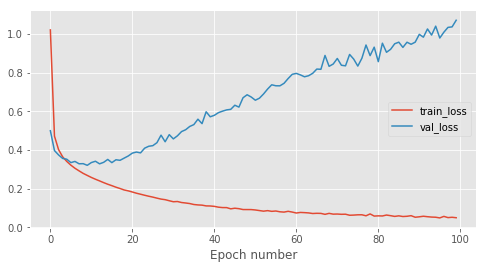

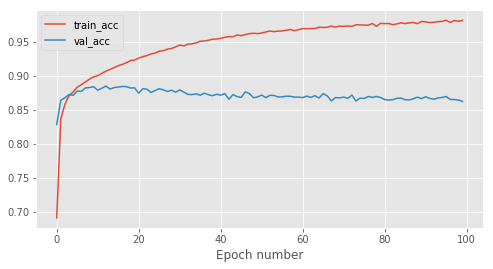

In [5]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [2,2,2,2]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [1,2,3,4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("maxpooling_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

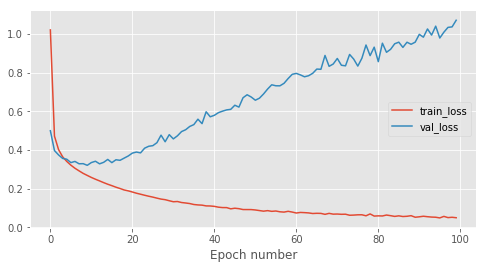

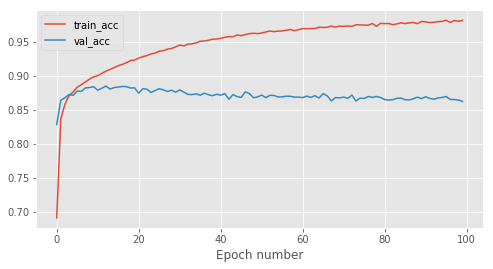

In [6]:
plot_stats_in_graph(total_losses[0])

In [ ]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [3,3,3,3]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [1,2,3,4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("avgpooling_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

In [ ]:
#stride
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [0]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("stride_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f2969cdc828>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29ae7d46d8>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29ae7d42b0>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 14, 14])


loss: 3.8524, accuracy: 0.0100:   0%|          | 2/1000 [00:00<00:33, 30.12it/s]

torch.Size([100, 64, 14, 14])
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 2, 2])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_

loss: 0.4082, accuracy: 0.8400:   1%|          | 7/1000 [00:00<00:24, 40.90it/s]

Epoch 0: train_acc_0.7320_train_loss_0.8763_val_acc_0.8444_val_loss_0.4702 epoch time 27.1805 seconds
total time0.0 : 27.180521249771118


loss: 0.3368, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.88it/s]

Epoch 1: train_acc_0.8498_train_loss_0.4278_val_acc_0.8630_val_loss_0.3964 epoch time 27.4408 seconds
total time0.0 : 54.62132549285889


loss: 0.2026, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 40.08it/s]

Epoch 2: train_acc_0.8671_train_loss_0.3673_val_acc_0.8700_val_loss_0.3707 epoch time 27.1989 seconds
total time1.0 : 21.820252180099487


loss: 0.2333, accuracy: 0.9200:   1%|          | 7/1000 [00:00<00:24, 39.80it/s]

Epoch 3: train_acc_0.8773_train_loss_0.3315_val_acc_0.8699_val_loss_0.3647 epoch time 27.2850 seconds
total time1.0 : 49.105268239974976


loss: 0.1900, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 40.80it/s]

Epoch 4: train_acc_0.8846_train_loss_0.3097_val_acc_0.8783_val_loss_0.3462 epoch time 26.6400 seconds
total time2.0 : 15.745293617248535


loss: 0.2511, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:24, 40.90it/s]

Epoch 5: train_acc_0.8903_train_loss_0.2883_val_acc_0.8799_val_loss_0.3364 epoch time 27.2104 seconds
total time2.0 : 42.95572519302368


loss: 0.1258, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 40.55it/s]

Epoch 6: train_acc_0.8954_train_loss_0.2707_val_acc_0.8838_val_loss_0.3350 epoch time 27.0797 seconds
total time3.0 : 10.035381555557251


loss: 0.2059, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:23, 41.68it/s]

Epoch 7: train_acc_0.9007_train_loss_0.2546_val_acc_0.8822_val_loss_0.3390 epoch time 27.2772 seconds
total time3.0 : 37.31257343292236


loss: 0.2593, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 38.68it/s]

Epoch 8: train_acc_0.9047_train_loss_0.2414_val_acc_0.8802_val_loss_0.3512 epoch time 27.2132 seconds
total time4.0 : 4.525737285614014


loss: 0.2496, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.71it/s]

Epoch 9: train_acc_0.9080_train_loss_0.2293_val_acc_0.8803_val_loss_0.3632 epoch time 27.0581 seconds
total time4.0 : 31.58382296562195


loss: 0.1332, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.02it/s]

Epoch 10: train_acc_0.9118_train_loss_0.2175_val_acc_0.8791_val_loss_0.3854 epoch time 27.0744 seconds
total time4.0 : 58.6582453250885


loss: 0.1922, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:24, 40.36it/s]

Epoch 11: train_acc_0.9144_train_loss_0.2081_val_acc_0.8763_val_loss_0.3692 epoch time 27.0902 seconds
total time5.0 : 25.748481273651123


loss: 0.1348, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:25, 39.54it/s]

Epoch 12: train_acc_0.9182_train_loss_0.1989_val_acc_0.8806_val_loss_0.3748 epoch time 27.1088 seconds
total time5.0 : 52.85731315612793


loss: 0.1209, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:23, 41.53it/s]

Epoch 13: train_acc_0.9214_train_loss_0.1896_val_acc_0.8828_val_loss_0.3984 epoch time 26.9817 seconds
total time6.0 : 19.83900284767151


loss: 0.1598, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 40.92it/s]

Epoch 14: train_acc_0.9230_train_loss_0.1850_val_acc_0.8805_val_loss_0.4036 epoch time 26.9619 seconds
total time6.0 : 46.80092430114746


loss: 0.1597, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:23, 41.85it/s]

Epoch 15: train_acc_0.9270_train_loss_0.1744_val_acc_0.8768_val_loss_0.4142 epoch time 26.8375 seconds
total time7.0 : 13.638463735580444


loss: 0.1243, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 40.74it/s]

Epoch 16: train_acc_0.9285_train_loss_0.1693_val_acc_0.8808_val_loss_0.4189 epoch time 26.9435 seconds
total time7.0 : 40.581955909729004


loss: 0.1406, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 41.33it/s]

Epoch 17: train_acc_0.9309_train_loss_0.1616_val_acc_0.8730_val_loss_0.4529 epoch time 27.0974 seconds
total time8.0 : 7.679320573806763


loss: 0.1503, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 41.31it/s]

Epoch 18: train_acc_0.9340_train_loss_0.1559_val_acc_0.8748_val_loss_0.4488 epoch time 27.0814 seconds
total time8.0 : 34.76069188117981


loss: 0.0664, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.16it/s]

Epoch 19: train_acc_0.9375_train_loss_0.1500_val_acc_0.8754_val_loss_0.4592 epoch time 26.9881 seconds
total time9.0 : 1.748790979385376


loss: 0.0578, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.96it/s]

Epoch 20: train_acc_0.9386_train_loss_0.1445_val_acc_0.8704_val_loss_0.4788 epoch time 27.0819 seconds
total time9.0 : 28.830713272094727


loss: 0.0905, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 40.46it/s]

Epoch 21: train_acc_0.9418_train_loss_0.1394_val_acc_0.8732_val_loss_0.5130 epoch time 27.0535 seconds
total time9.0 : 55.88425421714783


loss: 0.1228, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.66it/s]

Epoch 22: train_acc_0.9426_train_loss_0.1362_val_acc_0.8736_val_loss_0.5048 epoch time 27.0626 seconds
total time10.0 : 22.946898460388184


loss: 0.1302, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.79it/s]

Epoch 23: train_acc_0.9438_train_loss_0.1333_val_acc_0.8753_val_loss_0.5221 epoch time 26.9689 seconds
total time10.0 : 49.915815591812134


loss: 0.0992, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 41.31it/s]

Epoch 24: train_acc_0.9462_train_loss_0.1282_val_acc_0.8685_val_loss_0.5177 epoch time 27.1033 seconds
total time11.0 : 17.019161224365234


loss: 0.1406, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:23, 41.94it/s]

Epoch 25: train_acc_0.9476_train_loss_0.1230_val_acc_0.8761_val_loss_0.5137 epoch time 27.0083 seconds
total time11.0 : 44.02748346328735


loss: 0.0874, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 41.08it/s]

Epoch 26: train_acc_0.9487_train_loss_0.1213_val_acc_0.8704_val_loss_0.5339 epoch time 26.9439 seconds
total time12.0 : 10.971407175064087


loss: 0.1736, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 40.63it/s]

Epoch 27: train_acc_0.9491_train_loss_0.1191_val_acc_0.8734_val_loss_0.5608 epoch time 26.9274 seconds
total time12.0 : 37.89885449409485


loss: 0.0838, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:23, 41.54it/s]

Epoch 28: train_acc_0.9507_train_loss_0.1163_val_acc_0.8716_val_loss_0.5384 epoch time 27.0030 seconds
total time13.0 : 4.901809453964233


loss: 0.0729, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 41.25it/s]

Epoch 29: train_acc_0.9516_train_loss_0.1135_val_acc_0.8678_val_loss_0.5949 epoch time 27.1439 seconds
total time13.0 : 32.045750856399536


loss: 0.0775, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.31it/s]

Epoch 30: train_acc_0.9539_train_loss_0.1108_val_acc_0.8720_val_loss_0.5705 epoch time 27.5016 seconds
total time13.0 : 59.54733204841614


loss: 0.1157, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:25, 39.61it/s]

Epoch 31: train_acc_0.9560_train_loss_0.1061_val_acc_0.8738_val_loss_0.6094 epoch time 27.3819 seconds
total time14.0 : 26.929230451583862


loss: 0.0901, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:25, 38.63it/s]

Epoch 32: train_acc_0.9558_train_loss_0.1065_val_acc_0.8704_val_loss_0.6159 epoch time 27.8697 seconds
total time14.0 : 54.79894232749939


loss: 0.0832, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.98it/s]

Epoch 33: train_acc_0.9568_train_loss_0.1048_val_acc_0.8699_val_loss_0.6187 epoch time 27.0347 seconds
total time15.0 : 21.83361530303955


loss: 0.1109, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:24, 40.45it/s]

Epoch 34: train_acc_0.9593_train_loss_0.0981_val_acc_0.8724_val_loss_0.6616 epoch time 27.1424 seconds
total time15.0 : 48.976038694381714


loss: 0.0395, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.03it/s]

Epoch 35: train_acc_0.9590_train_loss_0.0987_val_acc_0.8712_val_loss_0.6729 epoch time 27.1885 seconds
total time16.0 : 16.164580821990967


loss: 0.0765, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 39.87it/s]

Epoch 36: train_acc_0.9597_train_loss_0.0981_val_acc_0.8669_val_loss_0.6600 epoch time 27.2391 seconds
total time16.0 : 43.40363597869873


loss: 0.1541, accuracy: 0.9500:  42%|████▏     | 418/1000 [00:10<00:14, 39.45it/s]

In [ ]:
#dilated
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [1,1,1,1]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [1,2,3,4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("dilated_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])